# Tracking the Growth of COVID-19 Cases

The purpose of this notebook is to infer the rate at which confirmed cases of COVID-19 are growing (or were growing) in various countries.

**The notebook pulls data from the Johns Hopkins [Data Repository](https://github.com/CSSEGISandData/COVID-19) of global Coronavirus COVID-19 cases**, and then does the following things:

- List cumulative number of confirmed cases (in countries with at least 100 confirmed cases)
- Attempt to fit the time series of cumulative confirmed cases to both an exponential and a logistic function
- Use these curve fits to infer doubling times (i.e., time for the number of cumulative confirmed cases to double)

We then repeat these steps for US states.

The notebook is updated approximately daily.

For a great primer on exponential and logistic growth, watch [this video](https://www.youtube.com/watch?v=Kas0tIxDvrg).

## Important Caveats:

- The growth rate (and the doubling time) changes with time. As the exponential curve eventually turns into a logistic curve, the growth rate will shrink to zero (& the doubling time will consequently increase). **So it's not a good idea to extrapolate trends far into the future based on current growth rates or doubling times.**

- The confirmed cases reported by each country are not the number of infections in each country, only those that have tested positive.

- The doubling time calculated here measures the growth of cumulative confirmed cases, which is different from the growth of infections. For example, if a country suddenly ramps up testing, then the number of confirmed cases will rapidly rise, but infections may not be rising as the same rate.

- The doubling times inferred from the curve fits are not necessarily the current or most recent doubling times: 
    - For countries where the growth is still exponential, the inferred doubling time gives us a picture of the overall rate of growth. 
    - For countries where the growth is no longer exponential, and the number of cases is stabilizing (such as China and South Korea), we use a logistic function to fit the data instead. Here, the inferred doubling time represents the growth encountered during the middle of the growth of the epidemic. 
    - Finally, we compare these values to the recent doubling time, calculated from the most recent week of data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

In [5]:
df.head()

Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  ...  3/23/20  3/24/20  3/25/20  3/26/20  \
0        0        0        0  ...       40       74       84       94   
1        0        0        0  ...      104      123      146      174   
2        0        0        0  ...      230      264      302      367   
3        0        0        0  ...      133      164      188      224   
4        0        0        0  ...        3        3        3        4   

   3/27/20  3/28/20  3/29/20  3/30/20  3/31/20  4/1/20  
0      110      110      120      170      174     237  
1      186      197      212      223      243     259  
2      409      454      511      584      716     847  
3      267      308      334      370      376     390  
4        4        5        7        7        7       8  

[5 rows x 75 columns]

## Global COVID-19 Analysis

In [4]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]
cases


Total number of cases (in countries with at least 100 cases) as of 4/1/20


4/1/20
Country/Region          
US                213372
Italy             110574
Spain             104118
China              82361
Germany            77872
...                  ...
Georgia              117
Bolivia              115
Kyrgyzstan           111
Cambodia             109
Congo (Kinshasa)     109

[111 rows x 1 columns]

## Curve Fitting Global COVID-19 Cases

In [6]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Original Data")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.95:
            plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
    except:
        pass
    
    plt.title(country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]



US

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 213372
	Confirmed cases on 3/25/20 	 65778
	Ratio: 3.24
	Weekly increase: 224.4 %
	Daily increase: 18.3 % per day
	Doubling Time (represents recent growth): 4.1 days

** Based on Exponential Fit **

	R^2: 0.9922944545236082
	Doubling Time (represents overall growth):  3.83 (± 0.17 ) days


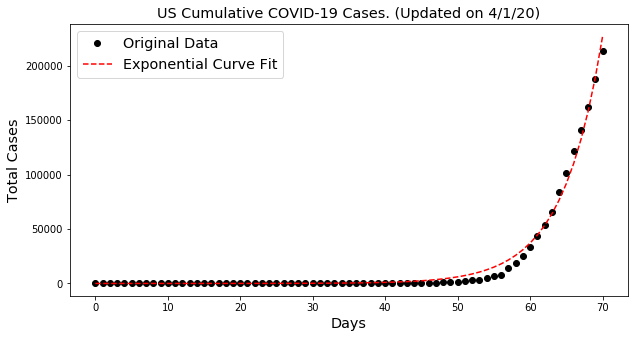



Italy

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 110574
	Confirmed cases on 3/25/20 	 74386
	Ratio: 1.49
	Weekly increase: 48.6 %
	Daily increase: 5.8 % per day
	Doubling Time (represents recent growth): 12.2 days

** Based on Logistic Fit**

	R^2: 0.9996910818533498
	Doubling Time (during middle of growth):  7.67 (± 0.17 ) days

** Based on Exponential Fit **

	R^2: 0.9510331317894433
	Doubling Time (represents overall growth):  5.85 (± 0.72 ) days


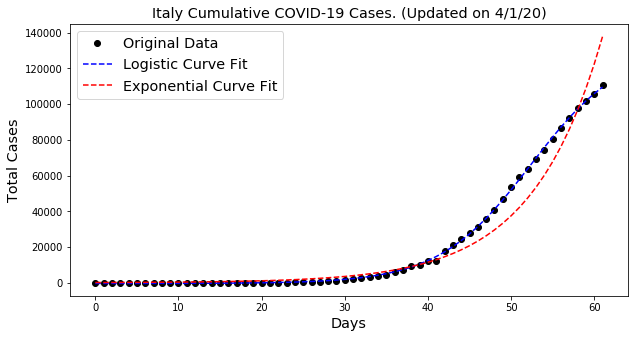



Spain

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 104118
	Confirmed cases on 3/25/20 	 49515
	Ratio: 2.1
	Weekly increase: 110.3 %
	Daily increase: 11.2 % per day
	Doubling Time (represents recent growth): 6.5 days

** Based on Logistic Fit**

	R^2: 0.9995335010465052
	Doubling Time (during middle of growth):  6.16 (± 0.18 ) days

** Based on Exponential Fit **

	R^2: 0.9877386152112312
	Doubling Time (represents overall growth):  5.13 (± 0.32 ) days


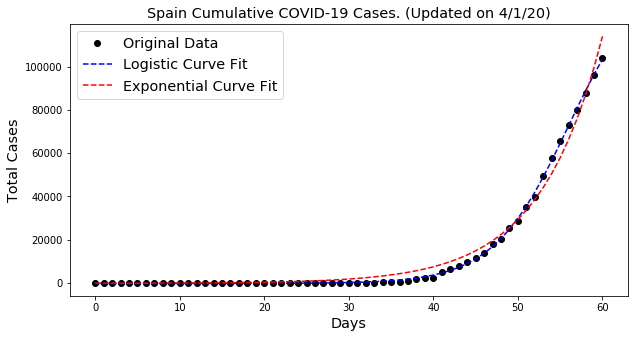



China

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 82361
	Confirmed cases on 3/25/20 	 81661
	Ratio: 1.01
	Weekly increase: 0.9 %
	Daily increase: 0.1 % per day
	Doubling Time (represents recent growth): 568.5 days

** Based on Logistic Fit**

	R^2: 0.9957798980667225
	Doubling Time (during middle of growth):  6.54 (± 0.48 ) days


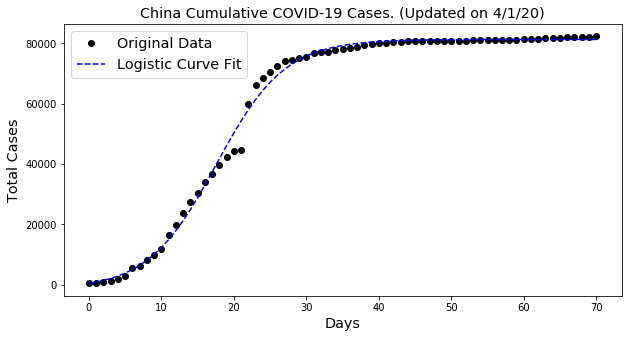



Germany

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 77872
	Confirmed cases on 3/25/20 	 37323
	Ratio: 2.09
	Weekly increase: 108.6 %
	Daily increase: 11.1 % per day
	Doubling Time (represents recent growth): 6.6 days

** Based on Logistic Fit**

	R^2: 0.999096853036842
	Doubling Time (during middle of growth):  6.3 (± 0.24 ) days

** Based on Exponential Fit **

	R^2: 0.985712574311706
	Doubling Time (represents overall growth):  5.4 (± 0.34 ) days


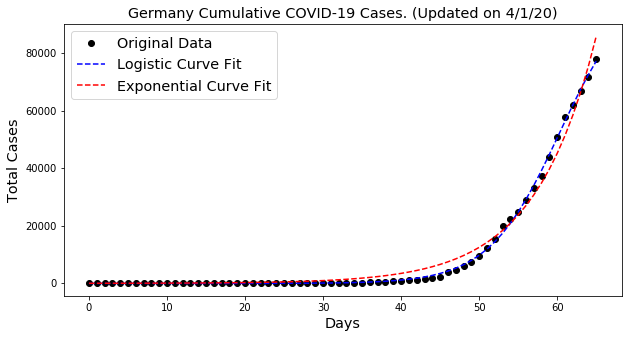



France

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 57749
	Confirmed cases on 3/25/20 	 25600
	Ratio: 2.26
	Weekly increase: 125.6 %
	Daily increase: 12.3 % per day
	Doubling Time (represents recent growth): 6.0 days

** Based on Logistic Fit**

	R^2: 0.9989942188891631
	Doubling Time (during middle of growth):  7.92 (± 0.34 ) days

** Based on Exponential Fit **

	R^2: 0.9951322549450683
	Doubling Time (represents overall growth):  5.3 (± 0.19 ) days


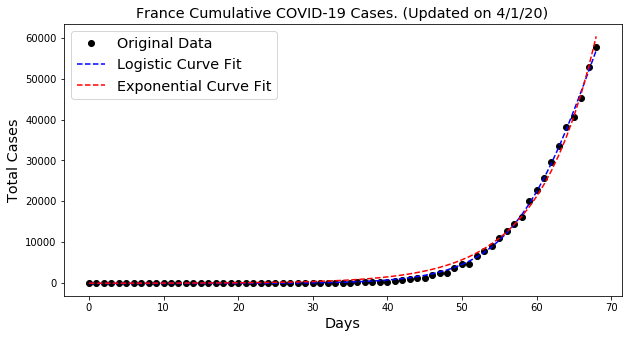



Iran

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 47593
	Confirmed cases on 3/25/20 	 27017
	Ratio: 1.76
	Weekly increase: 76.2 %
	Daily increase: 8.4 % per day
	Doubling Time (represents recent growth): 8.6 days

** Based on Logistic Fit**

	R^2: 0.9961523132295804
	Doubling Time (during middle of growth):  21.48 (± 6.52 ) days


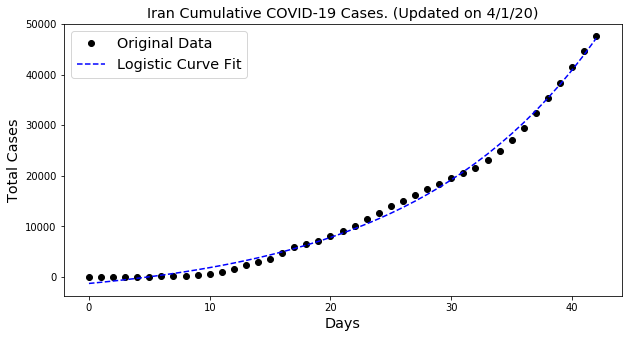



United Kingdom

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 29865
	Confirmed cases on 3/25/20 	 9640
	Ratio: 3.1
	Weekly increase: 209.8 %
	Daily increase: 17.5 % per day
	Doubling Time (represents recent growth): 4.3 days

** Based on Logistic Fit**

	R^2: 0.999353880711329
	Doubling Time (during middle of growth):  6.36 (± 0.23 ) days

** Based on Exponential Fit **

	R^2: 0.9965835657967795
	Doubling Time (represents overall growth):  4.23 (± 0.13 ) days


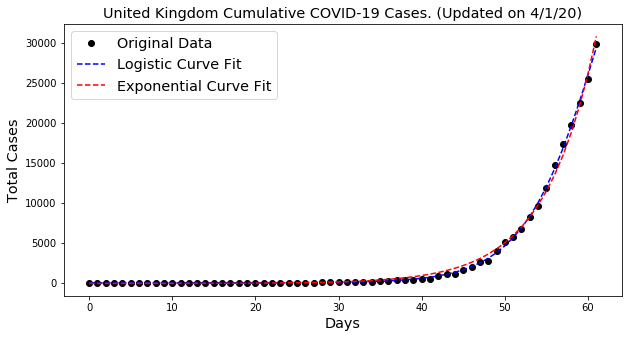



Switzerland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 17768
	Confirmed cases on 3/25/20 	 10897
	Ratio: 1.63
	Weekly increase: 63.1 %
	Daily increase: 7.2 % per day
	Doubling Time (represents recent growth): 9.9 days

** Based on Logistic Fit**

	R^2: 0.9988525144938495
	Doubling Time (during middle of growth):  5.7 (± 0.33 ) days


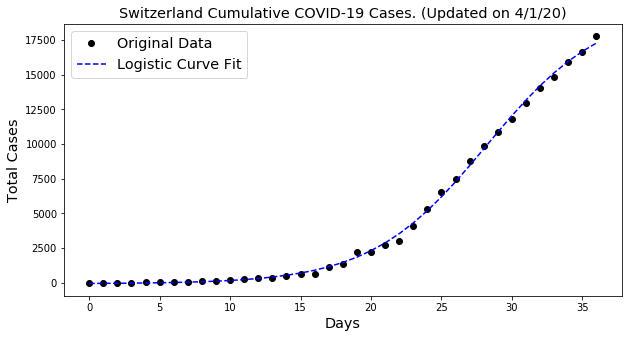



Turkey

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 15679
	Confirmed cases on 3/25/20 	 2433
	Ratio: 6.44
	Weekly increase: 544.4 %
	Daily increase: 30.5 % per day
	Doubling Time (represents recent growth): 2.6 days

** Based on Logistic Fit**

	R^2: 0.9982939534173668
	Doubling Time (during middle of growth):  3.65 (± 0.39 ) days

** Based on Exponential Fit **

	R^2: 0.9869388902677613
	Doubling Time (represents overall growth):  2.83 (± 0.35 ) days


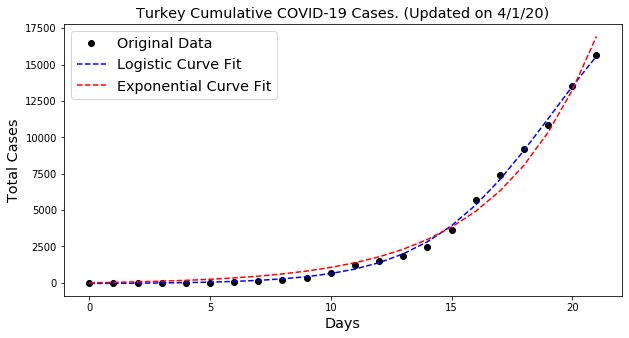



Belgium

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 13964
	Confirmed cases on 3/25/20 	 4937
	Ratio: 2.83
	Weekly increase: 182.8 %
	Daily increase: 16.0 % per day
	Doubling Time (represents recent growth): 4.7 days

** Based on Logistic Fit**

	R^2: 0.997670889085733
	Doubling Time (during middle of growth):  6.21 (± 0.44 ) days

** Based on Exponential Fit **

	R^2: 0.992452867044338
	Doubling Time (represents overall growth):  4.63 (± 0.23 ) days


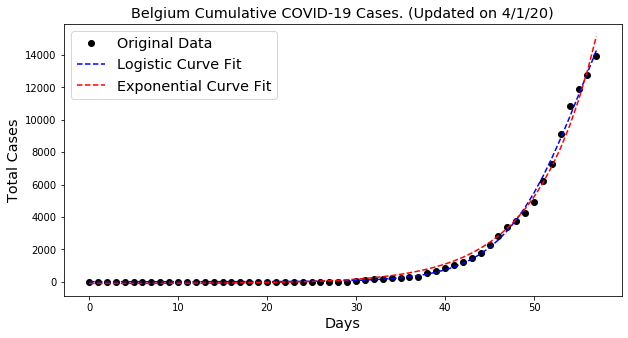



Netherlands

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 13696
	Confirmed cases on 3/25/20 	 6438
	Ratio: 2.13
	Weekly increase: 112.7 %
	Daily increase: 11.4 % per day
	Doubling Time (represents recent growth): 6.4 days

** Based on Logistic Fit**

	R^2: 0.9996216251266173
	Doubling Time (during middle of growth):  6.7 (± 0.26 ) days

** Based on Exponential Fit **

	R^2: 0.9793786290236491
	Doubling Time (represents overall growth):  4.67 (± 0.56 ) days


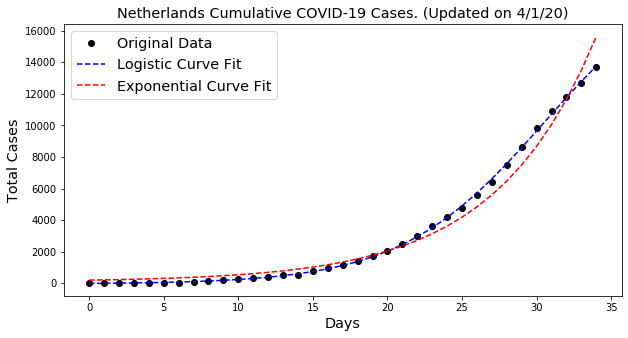



Austria

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 10711
	Confirmed cases on 3/25/20 	 5588
	Ratio: 1.92
	Weekly increase: 91.7 %
	Daily increase: 9.7 % per day
	Doubling Time (represents recent growth): 7.5 days

** Based on Logistic Fit**

	R^2: 0.9992573368441273
	Doubling Time (during middle of growth):  5.42 (± 0.25 ) days

** Based on Exponential Fit **

	R^2: 0.9705419125979072
	Doubling Time (represents overall growth):  5.16 (± 0.73 ) days


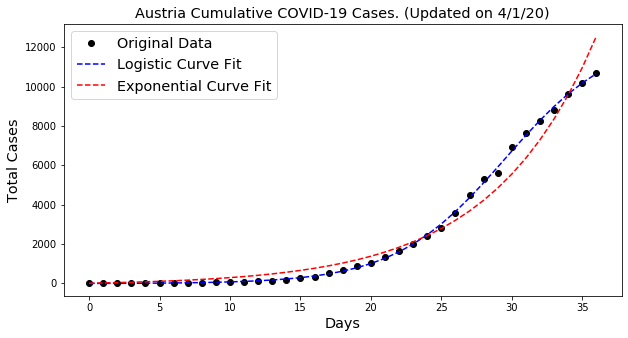



Korea, South

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 9887
	Confirmed cases on 3/25/20 	 9137
	Ratio: 1.08
	Weekly increase: 8.2 %
	Daily increase: 1.1 % per day
	Doubling Time (represents recent growth): 61.5 days

** Based on Logistic Fit**

	R^2: 0.9946685952493606
	Doubling Time (during middle of growth):  5.34 (± 0.46 ) days


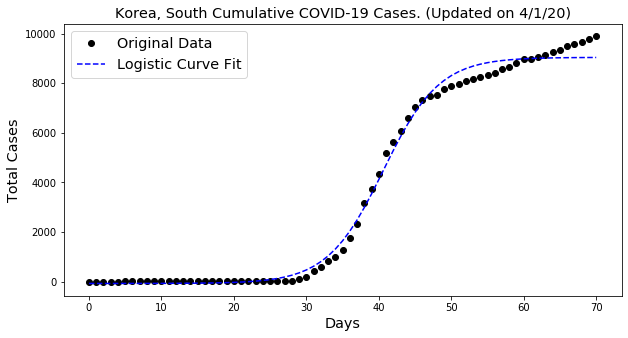



Canada

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 9560
	Confirmed cases on 3/25/20 	 3251
	Ratio: 2.94
	Weekly increase: 194.1 %
	Daily increase: 16.7 % per day
	Doubling Time (represents recent growth): 4.5 days

** Based on Exponential Fit **

	R^2: 0.993738949687301
	Doubling Time (represents overall growth):  4.11 (± 0.16 ) days


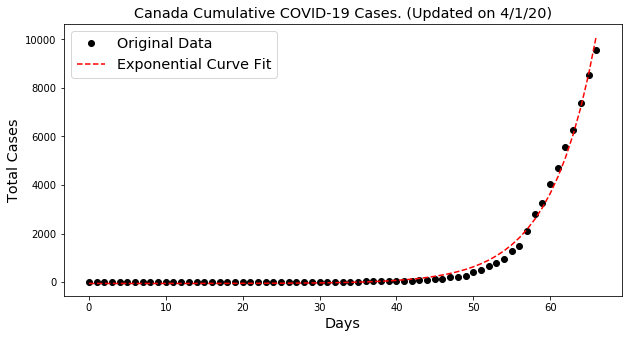



Portugal

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 8251
	Confirmed cases on 3/25/20 	 2995
	Ratio: 2.75
	Weekly increase: 175.5 %
	Daily increase: 15.6 % per day
	Doubling Time (represents recent growth): 4.8 days

** Based on Logistic Fit**

	R^2: 0.999238134019024
	Doubling Time (during middle of growth):  5.42 (± 0.32 ) days

** Based on Exponential Fit **

	R^2: 0.9900804775219528
	Doubling Time (represents overall growth):  4.34 (± 0.39 ) days


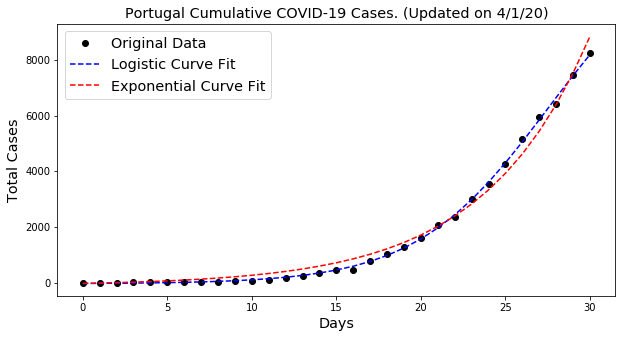



Brazil

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 6836
	Confirmed cases on 3/25/20 	 2554
	Ratio: 2.68
	Weekly increase: 167.7 %
	Daily increase: 15.1 % per day
	Doubling Time (represents recent growth): 4.9 days

** Based on Logistic Fit**

	R^2: 0.9924942616925652
	Doubling Time (during middle of growth):  6.71 (± 1.23 ) days

** Based on Exponential Fit **

	R^2: 0.9889922133092889
	Doubling Time (represents overall growth):  4.52 (± 0.38 ) days


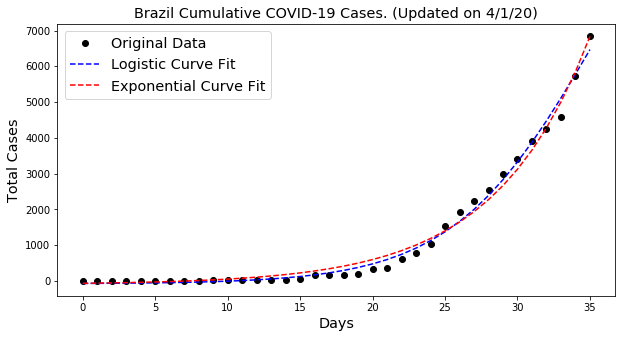



Israel

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 6092
	Confirmed cases on 3/25/20 	 2369
	Ratio: 2.57
	Weekly increase: 157.2 %
	Daily increase: 14.4 % per day
	Doubling Time (represents recent growth): 5.1 days

** Based on Logistic Fit**

	R^2: 0.9963749158507221
	Doubling Time (during middle of growth):  4.54 (± 0.46 ) days

** Based on Exponential Fit **

	R^2: 0.9861978574715725
	Doubling Time (represents overall growth):  4.13 (± 0.34 ) days


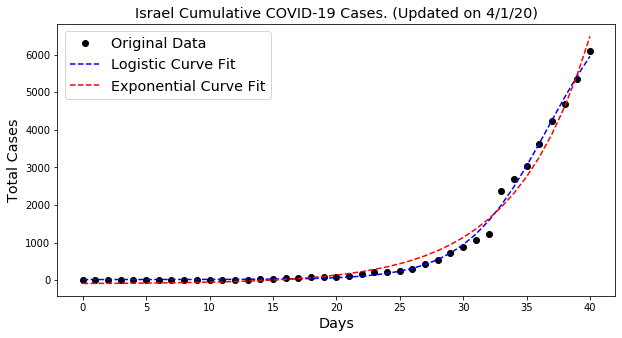



Sweden

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 4947
	Confirmed cases on 3/25/20 	 2526
	Ratio: 1.96
	Weekly increase: 95.8 %
	Daily increase: 10.1 % per day
	Doubling Time (represents recent growth): 7.2 days

** Based on Logistic Fit**

	R^2: 0.9956941439271058
	Doubling Time (during middle of growth):  10.99 (± 1.13 ) days

** Based on Exponential Fit **

	R^2: 0.9936126195802885
	Doubling Time (represents overall growth):  7.16 (± 0.33 ) days


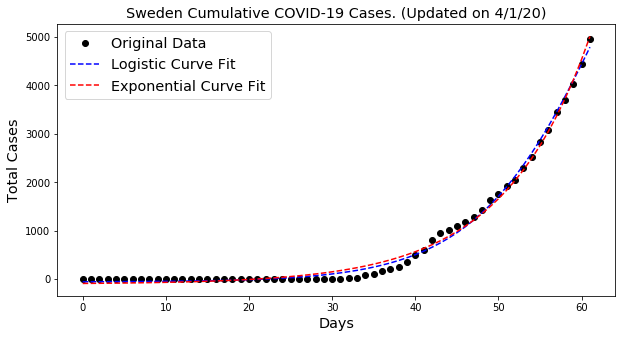



Norway

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 4863
	Confirmed cases on 3/25/20 	 3084
	Ratio: 1.58
	Weekly increase: 57.7 %
	Daily increase: 6.7 % per day
	Doubling Time (represents recent growth): 10.7 days

** Based on Logistic Fit**

	R^2: 0.9969140830853783
	Doubling Time (during middle of growth):  10.09 (± 1.41 ) days


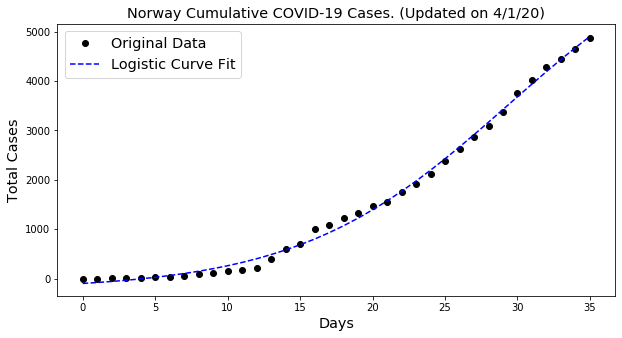



Australia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 4862
	Confirmed cases on 3/25/20 	 2364
	Ratio: 2.06
	Weekly increase: 105.7 %
	Daily increase: 10.9 % per day
	Doubling Time (represents recent growth): 6.7 days

** Based on Logistic Fit**

	R^2: 0.9993874313176319
	Doubling Time (during middle of growth):  5.14 (± 0.16 ) days

** Based on Exponential Fit **

	R^2: 0.9823824941904113
	Doubling Time (represents overall growth):  5.24 (± 0.36 ) days


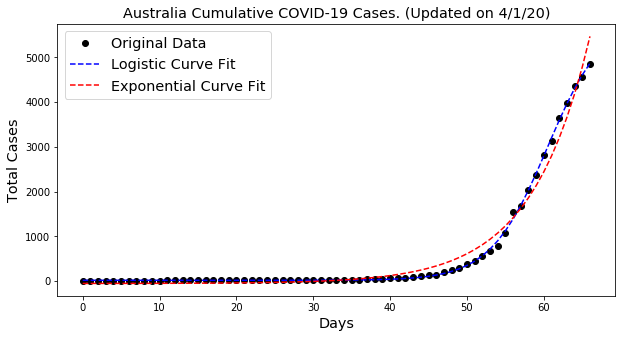



Czechia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 3508
	Confirmed cases on 3/25/20 	 1654
	Ratio: 2.12
	Weekly increase: 112.1 %
	Daily increase: 11.3 % per day
	Doubling Time (represents recent growth): 6.5 days

** Based on Logistic Fit**

	R^2: 0.9982307806593385
	Doubling Time (during middle of growth):  6.43 (± 0.58 ) days

** Based on Exponential Fit **

	R^2: 0.9860581780295017
	Doubling Time (represents overall growth):  5.64 (± 0.66 ) days


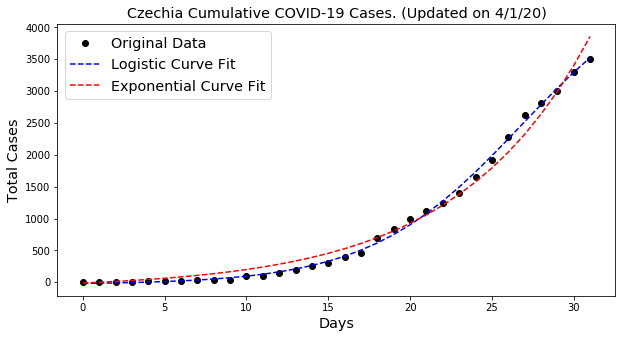



Ireland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 3447
	Confirmed cases on 3/25/20 	 1564
	Ratio: 2.2
	Weekly increase: 120.4 %
	Daily increase: 12.0 % per day
	Doubling Time (represents recent growth): 6.1 days

** Based on Logistic Fit**

	R^2: 0.9987617119628668
	Doubling Time (during middle of growth):  5.68 (± 0.4 ) days

** Based on Exponential Fit **

	R^2: 0.9860995578361704
	Doubling Time (represents overall growth):  5.22 (± 0.57 ) days


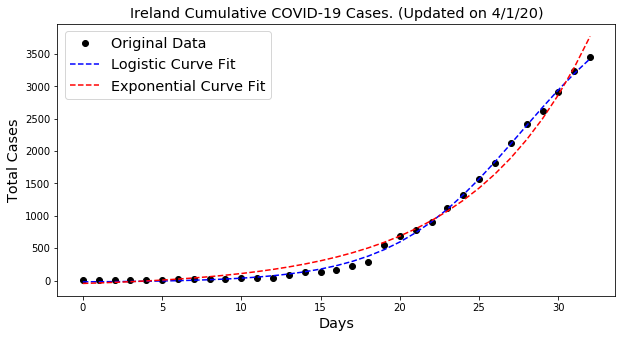



Denmark

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 3290
	Confirmed cases on 3/25/20 	 1862
	Ratio: 1.77
	Weekly increase: 76.7 %
	Daily increase: 8.5 % per day
	Doubling Time (represents recent growth): 8.5 days

** Based on Logistic Fit**

	R^2: 0.988385565596876
	Doubling Time (during middle of growth):  20.34 (± 15.63 ) days

** Based on Exponential Fit **

	R^2: 0.9559912179122911
	Doubling Time (represents overall growth):  6.62 (± 1.38 ) days


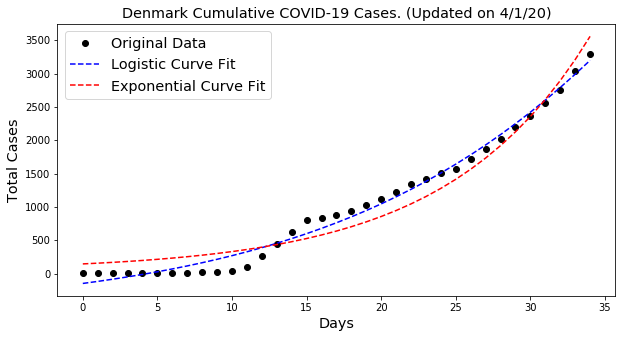



Chile

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 3031
	Confirmed cases on 3/25/20 	 1142
	Ratio: 2.65
	Weekly increase: 165.4 %
	Daily increase: 15.0 % per day
	Doubling Time (represents recent growth): 5.0 days

** Based on Logistic Fit**

	R^2: 0.9993044627127509
	Doubling Time (during middle of growth):  5.73 (± 0.34 ) days

** Based on Exponential Fit **

	R^2: 0.9930397647819625
	Doubling Time (represents overall growth):  4.7 (± 0.38 ) days


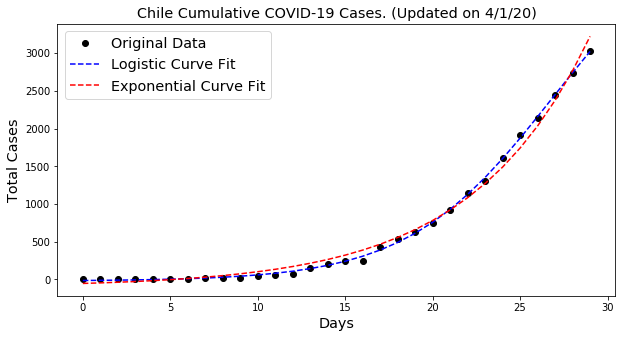



Malaysia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 2908
	Confirmed cases on 3/25/20 	 1796
	Ratio: 1.62
	Weekly increase: 61.9 %
	Daily increase: 7.1 % per day
	Doubling Time (represents recent growth): 10.1 days

** Based on Logistic Fit**

	R^2: 0.998480616744127
	Doubling Time (during middle of growth):  6.47 (± 0.31 ) days

** Based on Exponential Fit **

	R^2: 0.9785974172387865
	Doubling Time (represents overall growth):  6.96 (± 0.55 ) days


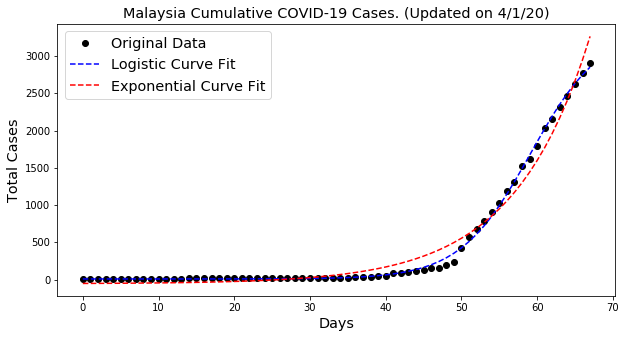



Russia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 2777
	Confirmed cases on 3/25/20 	 658
	Ratio: 4.22
	Weekly increase: 322.0 %
	Daily increase: 22.8 % per day
	Doubling Time (represents recent growth): 3.4 days

** Based on Exponential Fit **

	R^2: 0.9994227189810028
	Doubling Time (represents overall growth):  3.39 (± 0.04 ) days


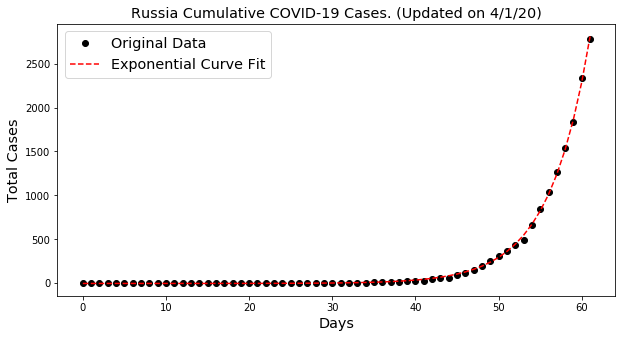



Ecuador

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 2748
	Confirmed cases on 3/25/20 	 1173
	Ratio: 2.34
	Weekly increase: 134.3 %
	Daily increase: 12.9 % per day
	Doubling Time (represents recent growth): 5.7 days

** Based on Logistic Fit**

	R^2: 0.9874989934843337
	Doubling Time (during middle of growth):  4.96 (± 1.05 ) days

** Based on Exponential Fit **

	R^2: 0.9705767100087055
	Doubling Time (represents overall growth):  5.18 (± 0.85 ) days


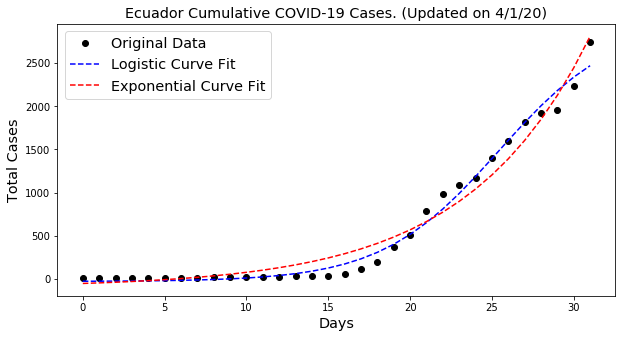



Poland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 2554
	Confirmed cases on 3/25/20 	 1051
	Ratio: 2.43
	Weekly increase: 143.0 %
	Daily increase: 13.5 % per day
	Doubling Time (represents recent growth): 5.5 days

** Based on Logistic Fit**

	R^2: 0.9996772048953901
	Doubling Time (during middle of growth):  6.8 (± 0.32 ) days

** Based on Exponential Fit **

	R^2: 0.9952517371176811
	Doubling Time (represents overall growth):  5.21 (± 0.38 ) days


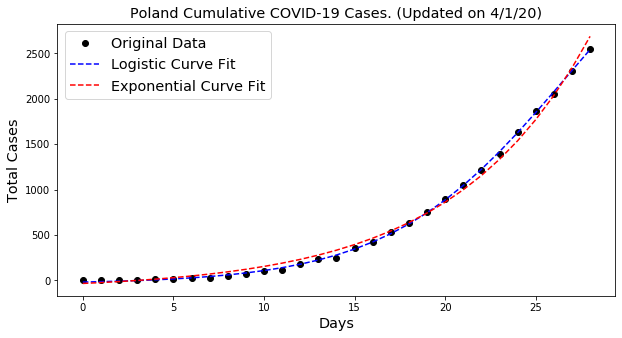



Romania

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 2460
	Confirmed cases on 3/25/20 	 906
	Ratio: 2.72
	Weekly increase: 171.5 %
	Daily increase: 15.3 % per day
	Doubling Time (represents recent growth): 4.9 days

** Based on Logistic Fit**

	R^2: 0.9977562894279214
	Doubling Time (during middle of growth):  5.63 (± 0.52 ) days

** Based on Exponential Fit **

	R^2: 0.9920604036197196
	Doubling Time (represents overall growth):  4.57 (± 0.32 ) days


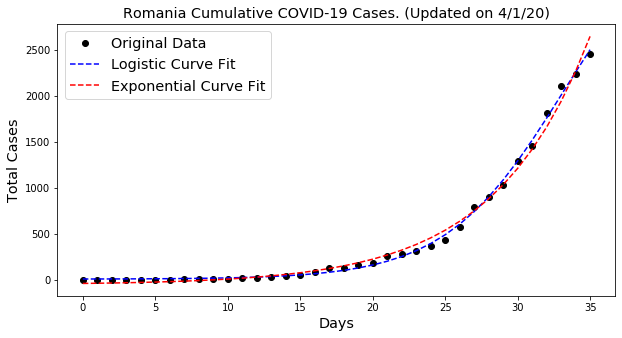



Luxembourg

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 2319
	Confirmed cases on 3/25/20 	 1333
	Ratio: 1.74
	Weekly increase: 74.0 %
	Daily increase: 8.2 % per day
	Doubling Time (represents recent growth): 8.8 days

** Based on Logistic Fit**

	R^2: 0.9976380553351525
	Doubling Time (during middle of growth):  4.48 (± 0.38 ) days

** Based on Exponential Fit **

	R^2: 0.9649504251602224
	Doubling Time (represents overall growth):  5.75 (± 1.07 ) days


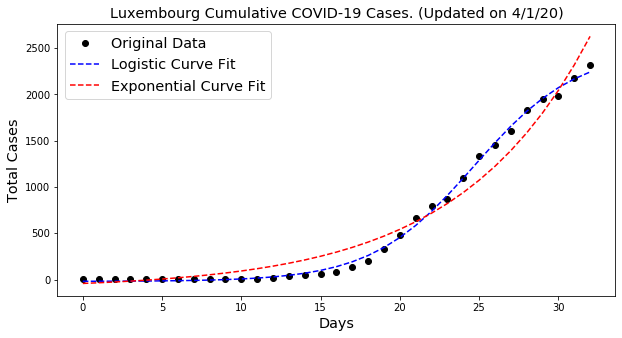



Philippines

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 2311
	Confirmed cases on 3/25/20 	 636
	Ratio: 3.63
	Weekly increase: 263.4 %
	Daily increase: 20.2 % per day
	Doubling Time (represents recent growth): 3.8 days

** Based on Exponential Fit **

	R^2: 0.9959957743285213
	Doubling Time (represents overall growth):  3.67 (± 0.12 ) days


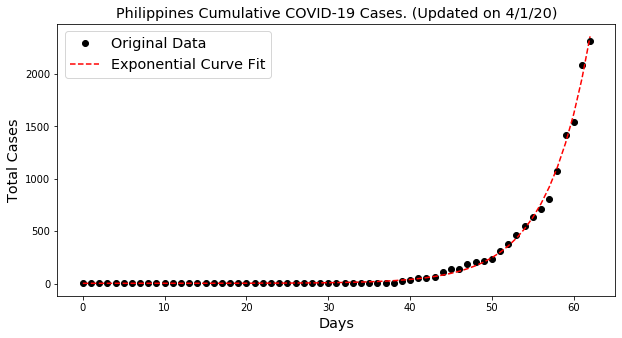



Japan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 2178
	Confirmed cases on 3/25/20 	 1307
	Ratio: 1.67
	Weekly increase: 66.6 %
	Daily increase: 7.6 % per day
	Doubling Time (represents recent growth): 9.5 days

** Based on Logistic Fit**

	R^2: 0.9943921220772035
	Doubling Time (during middle of growth):  23.24 (± 4.0 ) days

** Based on Exponential Fit **

	R^2: 0.9943921224781739
	Doubling Time (represents overall growth):  11.62 (± 0.53 ) days


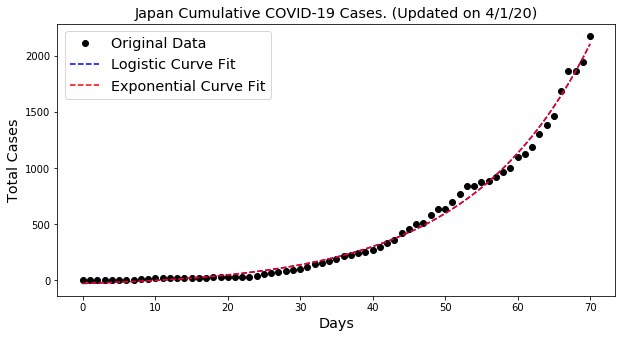



Pakistan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 2118
	Confirmed cases on 3/25/20 	 1063
	Ratio: 1.99
	Weekly increase: 99.2 %
	Daily increase: 10.3 % per day
	Doubling Time (represents recent growth): 7.0 days

** Based on Logistic Fit**

	R^2: 0.9933245361756121
	Doubling Time (during middle of growth):  6.14 (± 0.92 ) days

** Based on Exponential Fit **

	R^2: 0.9788318412538675
	Doubling Time (represents overall growth):  6.12 (± 0.81 ) days


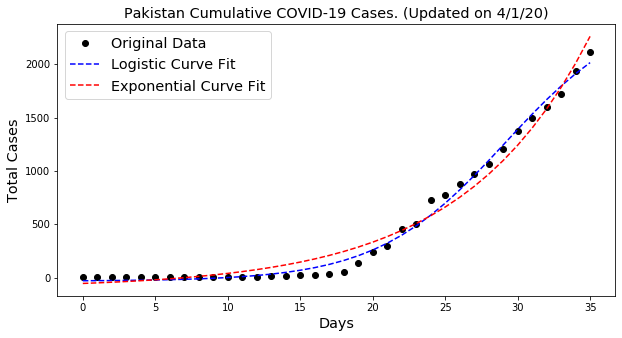



India

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 1998
	Confirmed cases on 3/25/20 	 657
	Ratio: 3.04
	Weekly increase: 204.1 %
	Daily increase: 17.2 % per day
	Doubling Time (represents recent growth): 4.4 days

** Based on Exponential Fit **

	R^2: 0.9906325138547891
	Doubling Time (represents overall growth):  4.34 (± 0.22 ) days


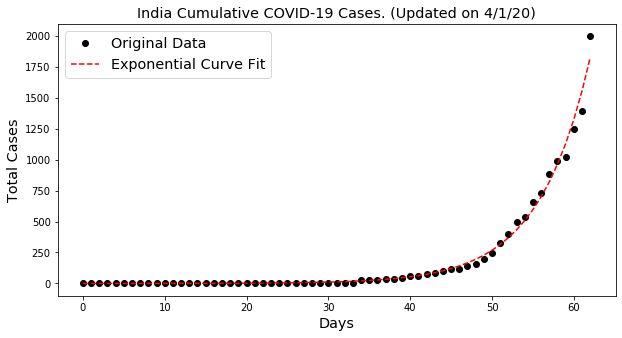



Thailand

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 1771
	Confirmed cases on 3/25/20 	 934
	Ratio: 1.9
	Weekly increase: 89.6 %
	Daily increase: 9.6 % per day
	Doubling Time (represents recent growth): 7.6 days

** Based on Exponential Fit **

	R^2: 0.9805983252785744
	Doubling Time (represents overall growth):  5.35 (± 0.37 ) days


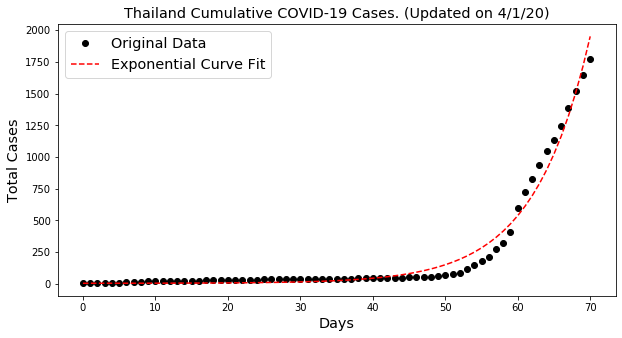



Saudi Arabia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 1720
	Confirmed cases on 3/25/20 	 900
	Ratio: 1.91
	Weekly increase: 91.1 %
	Daily increase: 9.7 % per day
	Doubling Time (represents recent growth): 7.5 days

** Based on Logistic Fit**

	R^2: 0.9977174344771584
	Doubling Time (during middle of growth):  5.6 (± 0.54 ) days

** Based on Exponential Fit **

	R^2: 0.9845713673335991
	Doubling Time (represents overall growth):  5.97 (± 0.78 ) days


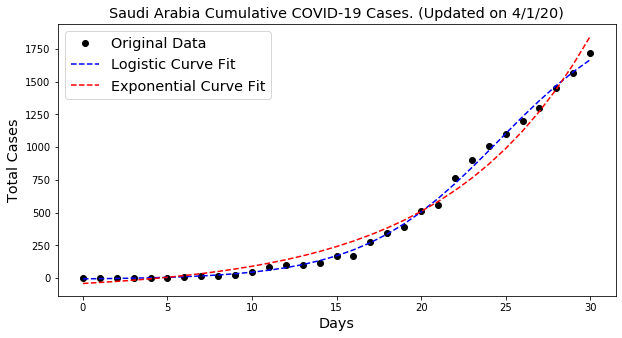



Indonesia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 1677
	Confirmed cases on 3/25/20 	 790
	Ratio: 2.12
	Weekly increase: 112.3 %
	Daily increase: 11.4 % per day
	Doubling Time (represents recent growth): 6.4 days

** Based on Logistic Fit**

	R^2: 0.9993077604425037
	Doubling Time (during middle of growth):  6.84 (± 0.42 ) days

** Based on Exponential Fit **

	R^2: 0.992591699355046
	Doubling Time (represents overall growth):  6.06 (± 0.55 ) days


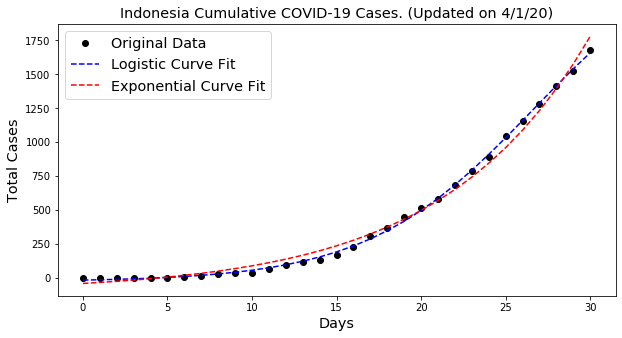



Finland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 1446
	Confirmed cases on 3/25/20 	 880
	Ratio: 1.64
	Weekly increase: 64.3 %
	Daily increase: 7.4 % per day
	Doubling Time (represents recent growth): 9.8 days

** Based on Logistic Fit**

	R^2: 0.9980343552213709
	Doubling Time (during middle of growth):  6.98 (± 0.4 ) days

** Based on Exponential Fit **

	R^2: 0.9828288247943575
	Doubling Time (represents overall growth):  6.76 (± 0.49 ) days


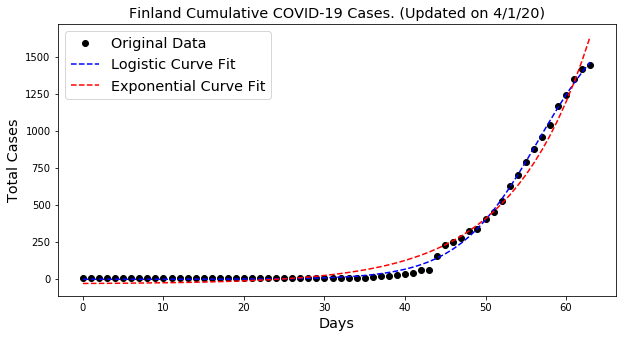



Greece

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 1415
	Confirmed cases on 3/25/20 	 821
	Ratio: 1.72
	Weekly increase: 72.4 %
	Daily increase: 8.1 % per day
	Doubling Time (represents recent growth): 8.9 days

** Based on Logistic Fit**

	R^2: 0.9968228750144328
	Doubling Time (during middle of growth):  10.43 (± 1.57 ) days

** Based on Exponential Fit **

	R^2: 0.991782196066927
	Doubling Time (represents overall growth):  8.18 (± 0.8 ) days


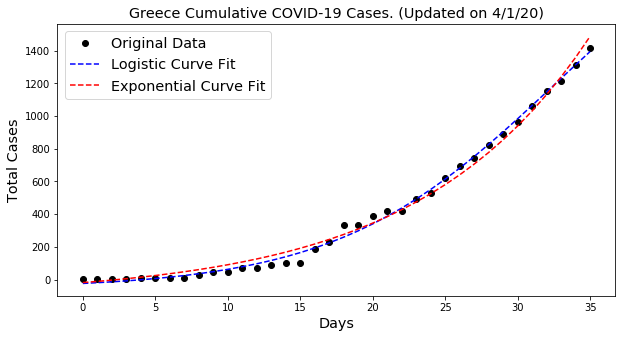



South Africa

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 1380
	Confirmed cases on 3/25/20 	 709
	Ratio: 1.95
	Weekly increase: 94.6 %
	Daily increase: 10.0 % per day
	Doubling Time (represents recent growth): 7.3 days

** Based on Logistic Fit**

	R^2: 0.9961243354430729
	Doubling Time (during middle of growth):  2.85 (± 0.33 ) days


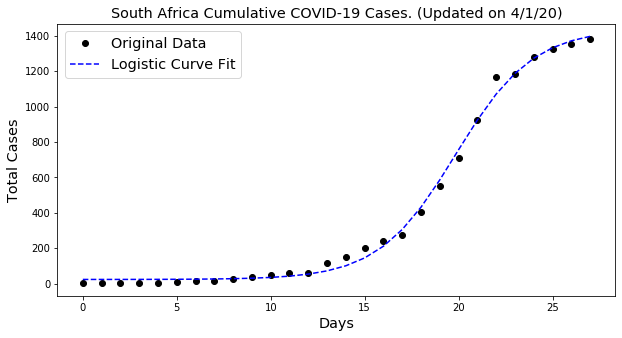



Peru

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 1323
	Confirmed cases on 3/25/20 	 480
	Ratio: 2.76
	Weekly increase: 175.6 %
	Daily increase: 15.6 % per day
	Doubling Time (represents recent growth): 4.8 days

** Based on Logistic Fit**

	R^2: 0.9930850891715917
	Doubling Time (during middle of growth):  11.19 (± 2.41 ) days

** Based on Exponential Fit **

	R^2: 0.9930850894617061
	Doubling Time (represents overall growth):  5.6 (± 0.55 ) days


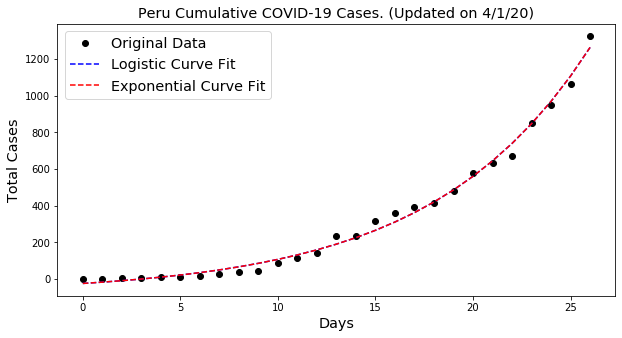



Dominican Republic

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 1284
	Confirmed cases on 3/25/20 	 392
	Ratio: 3.28
	Weekly increase: 227.6 %
	Daily increase: 18.5 % per day
	Doubling Time (represents recent growth): 4.1 days

** Based on Logistic Fit**

	R^2: 0.9964282260785245
	Doubling Time (during middle of growth):  4.81 (± 0.58 ) days

** Based on Exponential Fit **

	R^2: 0.9891311686775566
	Doubling Time (represents overall growth):  4.0 (± 0.35 ) days


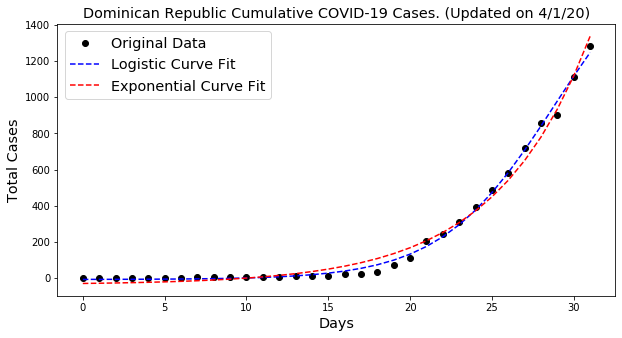



Iceland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 1220
	Confirmed cases on 3/25/20 	 737
	Ratio: 1.66
	Weekly increase: 65.5 %
	Daily increase: 7.5 % per day
	Doubling Time (represents recent growth): 9.6 days

** Based on Logistic Fit**

	R^2: 0.9984888856067343
	Doubling Time (during middle of growth):  6.94 (± 0.54 ) days

** Based on Exponential Fit **

	R^2: 0.9863950595671762
	Doubling Time (represents overall growth):  7.88 (± 1.03 ) days


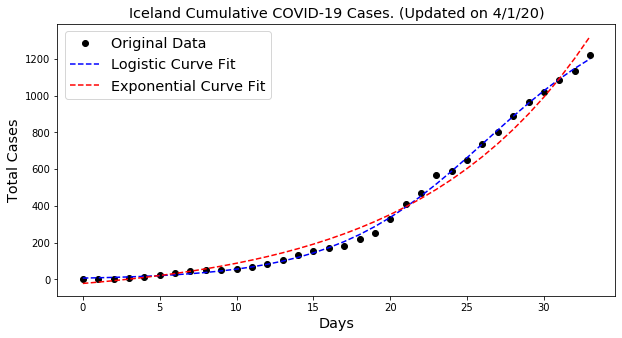



Mexico

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 1215
	Confirmed cases on 3/25/20 	 405
	Ratio: 3.0
	Weekly increase: 200.0 %
	Daily increase: 17.0 % per day
	Doubling Time (represents recent growth): 4.4 days

** Based on Logistic Fit**

	R^2: 0.9984618407366094
	Doubling Time (during middle of growth):  6.06 (± 0.51 ) days

** Based on Exponential Fit **

	R^2: 0.9945904419125068
	Doubling Time (represents overall growth):  4.49 (± 0.27 ) days


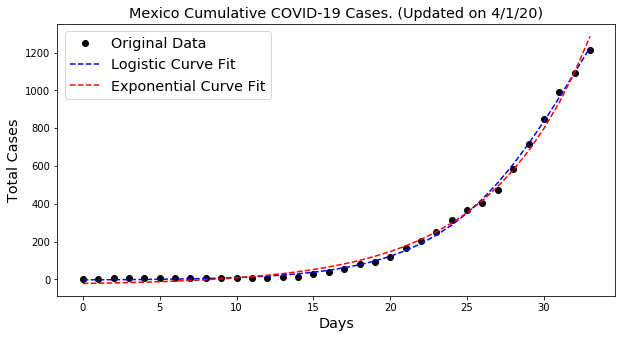



Panama

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 1181
	Confirmed cases on 3/25/20 	 443
	Ratio: 2.67
	Weekly increase: 166.6 %
	Daily increase: 15.0 % per day
	Doubling Time (represents recent growth): 4.9 days

** Based on Logistic Fit**

	R^2: 0.9959004309662287
	Doubling Time (during middle of growth):  5.34 (± 0.97 ) days

** Based on Exponential Fit **

	R^2: 0.9885513056708185
	Doubling Time (represents overall growth):  5.31 (± 0.79 ) days


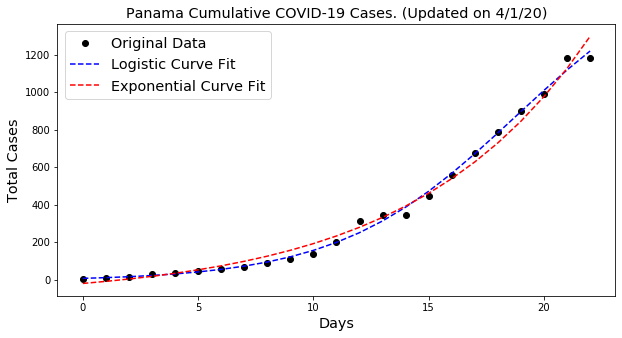



Colombia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 1065
	Confirmed cases on 3/25/20 	 470
	Ratio: 2.27
	Weekly increase: 126.6 %
	Daily increase: 12.4 % per day
	Doubling Time (represents recent growth): 5.9 days

** Based on Logistic Fit**

	R^2: 0.994933571796302
	Doubling Time (during middle of growth):  7.13 (± 1.52 ) days

** Based on Exponential Fit **

	R^2: 0.9926934263871678
	Doubling Time (represents overall growth):  5.41 (± 0.53 ) days


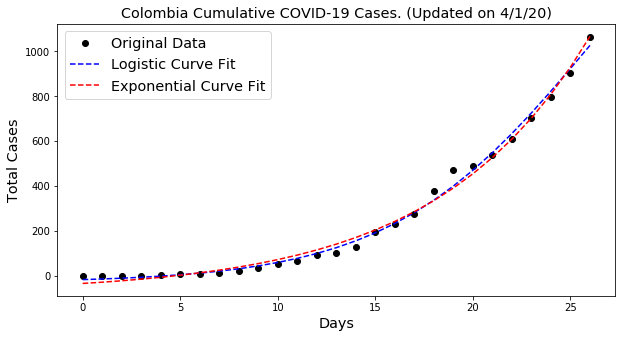



Serbia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 1060
	Confirmed cases on 3/25/20 	 384
	Ratio: 2.76
	Weekly increase: 176.0 %
	Daily increase: 15.6 % per day
	Doubling Time (represents recent growth): 4.8 days

** Based on Logistic Fit**

	R^2: 0.994965119638513
	Doubling Time (during middle of growth):  6.7 (± 1.39 ) days

** Based on Exponential Fit **

	R^2: 0.9933121571184795
	Doubling Time (represents overall growth):  4.71 (± 0.41 ) days


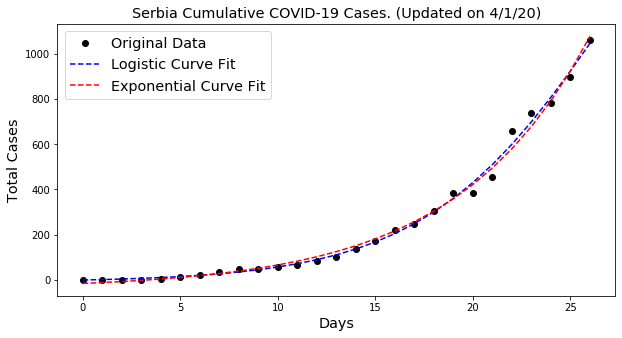



Argentina

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 1054
	Confirmed cases on 3/25/20 	 387
	Ratio: 2.72
	Weekly increase: 172.4 %
	Daily increase: 15.4 % per day
	Doubling Time (represents recent growth): 4.8 days

** Based on Logistic Fit**

	R^2: 0.9945291254561183
	Doubling Time (during middle of growth):  5.75 (± 0.96 ) days

** Based on Exponential Fit **

	R^2: 0.9883232606241656
	Doubling Time (represents overall growth):  5.0 (± 0.53 ) days


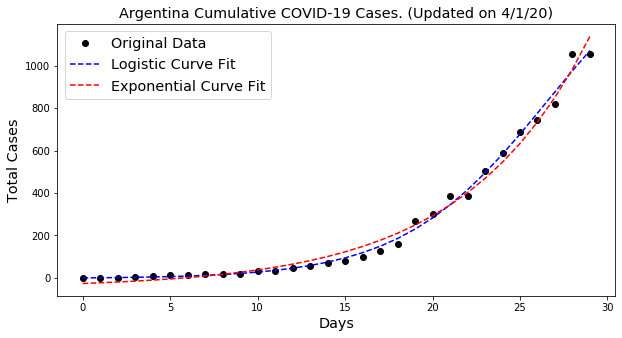



Singapore

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 1000
	Confirmed cases on 3/25/20 	 631
	Ratio: 1.58
	Weekly increase: 58.5 %
	Daily increase: 6.8 % per day
	Doubling Time (represents recent growth): 10.5 days

** Based on Logistic Fit**

	R^2: 0.9923088703991141
	Doubling Time (during middle of growth):  12.91 (± 1.73 ) days

** Based on Exponential Fit **

	R^2: 0.9915388777625165
	Doubling Time (represents overall growth):  8.09 (± 0.4 ) days


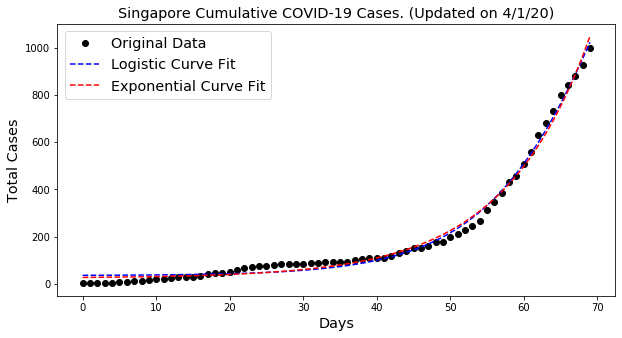



Croatia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 963
	Confirmed cases on 3/25/20 	 442
	Ratio: 2.18
	Weekly increase: 117.9 %
	Daily increase: 11.8 % per day
	Doubling Time (represents recent growth): 6.2 days

** Based on Logistic Fit**

	R^2: 0.99827924401541
	Doubling Time (during middle of growth):  5.25 (± 0.38 ) days

** Based on Exponential Fit **

	R^2: 0.9852863939275792
	Doubling Time (represents overall growth):  5.32 (± 0.53 ) days


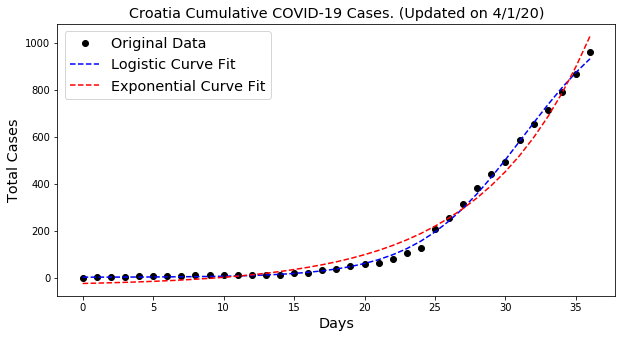



Algeria

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 847
	Confirmed cases on 3/25/20 	 302
	Ratio: 2.8
	Weekly increase: 180.5 %
	Daily increase: 15.9 % per day
	Doubling Time (represents recent growth): 4.7 days

** Based on Logistic Fit**

	R^2: 0.99548666416648
	Doubling Time (during middle of growth):  7.98 (± 1.27 ) days

** Based on Exponential Fit **

	R^2: 0.9950909814601077
	Doubling Time (represents overall growth):  4.58 (± 0.25 ) days


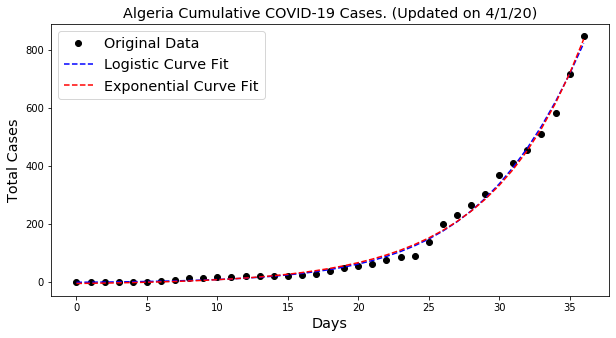



Slovenia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 841
	Confirmed cases on 3/25/20 	 528
	Ratio: 1.59
	Weekly increase: 59.3 %
	Daily increase: 6.9 % per day
	Doubling Time (represents recent growth): 10.4 days

** Based on Logistic Fit**

	R^2: 0.9947678653314349
	Doubling Time (during middle of growth):  16.82 (± 10.04 ) days

** Based on Exponential Fit **

	R^2: 0.9708312235095607
	Doubling Time (represents overall growth):  8.16 (± 2.09 ) days


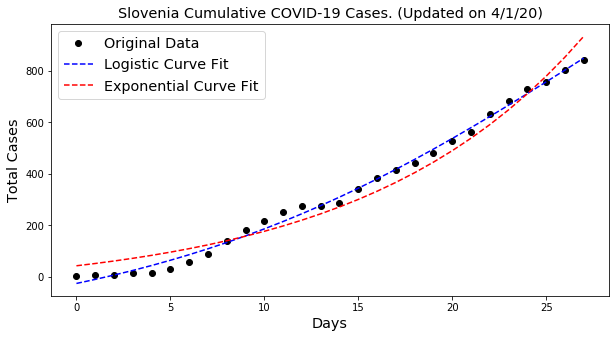



Qatar

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 835
	Confirmed cases on 3/25/20 	 537
	Ratio: 1.55
	Weekly increase: 55.5 %
	Daily increase: 6.5 % per day
	Doubling Time (represents recent growth): 11.0 days


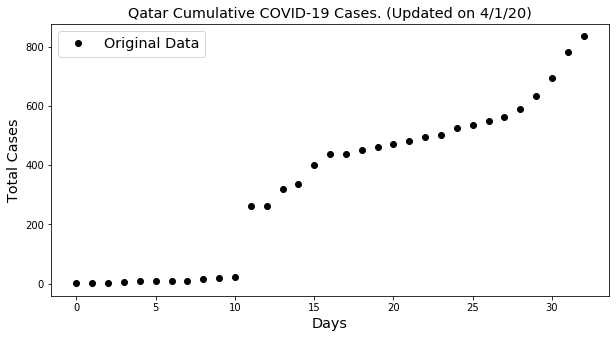



United Arab Emirates

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 814
	Confirmed cases on 3/25/20 	 333
	Ratio: 2.44
	Weekly increase: 144.4 %
	Daily increase: 13.6 % per day
	Doubling Time (represents recent growth): 5.4 days

** Based on Exponential Fit **

	R^2: 0.9935958639246203
	Doubling Time (represents overall growth):  4.87 (± 0.21 ) days


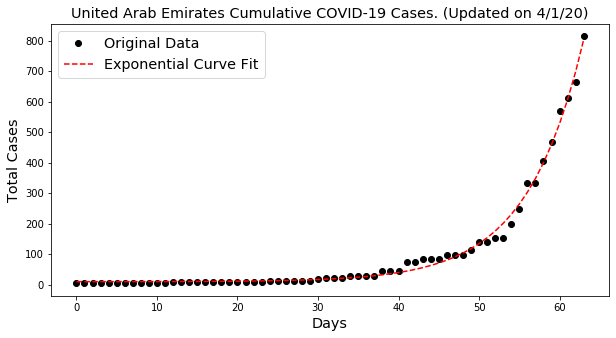



Ukraine

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 794
	Confirmed cases on 3/25/20 	 145
	Ratio: 5.48
	Weekly increase: 447.6 %
	Daily increase: 27.5 % per day
	Doubling Time (represents recent growth): 2.9 days

** Based on Logistic Fit**

	R^2: 0.997499102798668
	Doubling Time (during middle of growth):  3.95 (± 0.42 ) days

** Based on Exponential Fit **

	R^2: 0.99143106179443
	Doubling Time (represents overall growth):  3.17 (± 0.25 ) days


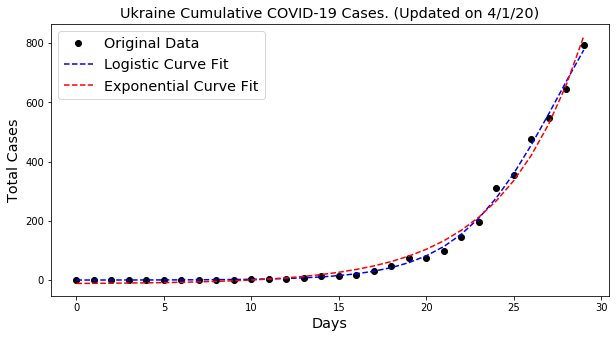



Estonia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 779
	Confirmed cases on 3/25/20 	 404
	Ratio: 1.93
	Weekly increase: 92.8 %
	Daily increase: 9.8 % per day
	Doubling Time (represents recent growth): 7.4 days

** Based on Logistic Fit**

	R^2: 0.9858773491438894
	Doubling Time (during middle of growth):  9.36 (± 2.77 ) days

** Based on Exponential Fit **

	R^2: 0.9804251291298356
	Doubling Time (represents overall growth):  8.78 (± 1.43 ) days


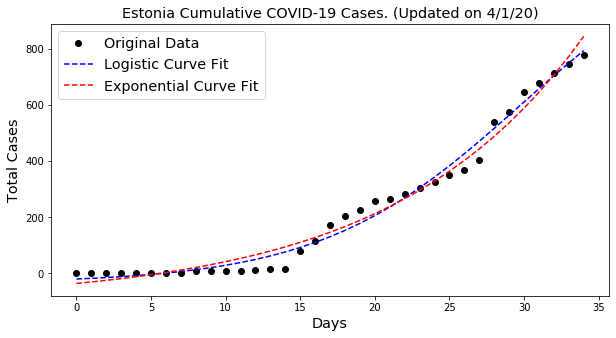



Egypt

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 779
	Confirmed cases on 3/25/20 	 456
	Ratio: 1.71
	Weekly increase: 70.8 %
	Daily increase: 8.0 % per day
	Doubling Time (represents recent growth): 9.1 days

** Based on Logistic Fit**

	R^2: 0.9974157793172789
	Doubling Time (during middle of growth):  8.48 (± 0.71 ) days

** Based on Exponential Fit **

	R^2: 0.9891553573264054
	Doubling Time (represents overall growth):  7.71 (± 0.6 ) days


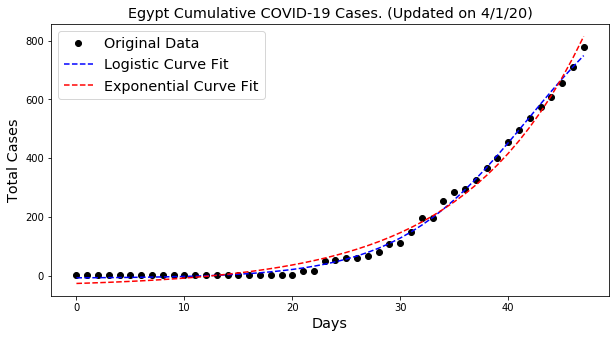



Iraq

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 728
	Confirmed cases on 3/25/20 	 346
	Ratio: 2.1
	Weekly increase: 110.4 %
	Daily increase: 11.2 % per day
	Doubling Time (represents recent growth): 6.5 days

** Based on Logistic Fit**

	R^2: 0.9974122401909716
	Doubling Time (during middle of growth):  12.42 (± 2.06 ) days

** Based on Exponential Fit **

	R^2: 0.9973904054423617
	Doubling Time (represents overall growth):  6.5 (± 0.29 ) days


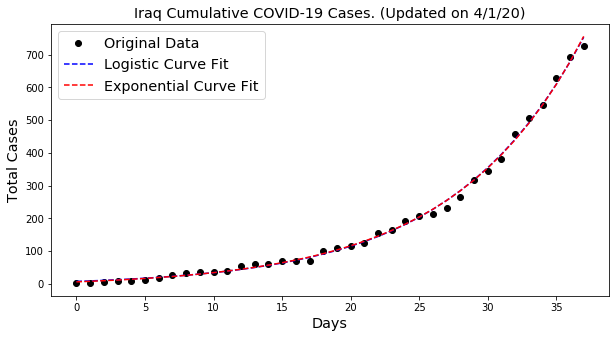



Diamond Princess

** Based on Logistic Fit**

	R^2: 0.9962117308926735
	Doubling Time (during middle of growth):  2.81 (± 0.24 ) days


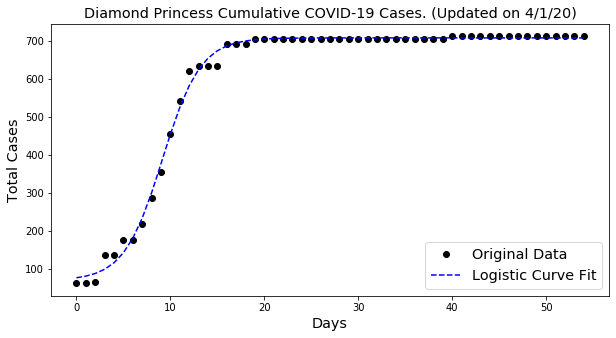



New Zealand

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 708
	Confirmed cases on 3/25/20 	 205
	Ratio: 3.45
	Weekly increase: 245.4 %
	Daily increase: 19.4 % per day
	Doubling Time (represents recent growth): 3.9 days

** Based on Logistic Fit**

	R^2: 0.9992927134370637
	Doubling Time (during middle of growth):  3.47 (± 0.16 ) days

** Based on Exponential Fit **

	R^2: 0.9782706406838373
	Doubling Time (represents overall growth):  3.97 (± 0.47 ) days


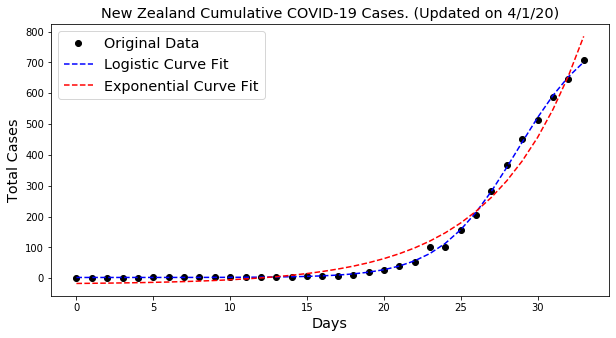



Morocco

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 654
	Confirmed cases on 3/25/20 	 225
	Ratio: 2.91
	Weekly increase: 190.7 %
	Daily increase: 16.5 % per day
	Doubling Time (represents recent growth): 4.5 days

** Based on Logistic Fit**

	R^2: 0.9989219393072014
	Doubling Time (during middle of growth):  4.91 (± 0.33 ) days

** Based on Exponential Fit **

	R^2: 0.990382756850114
	Doubling Time (represents overall growth):  4.48 (± 0.4 ) days


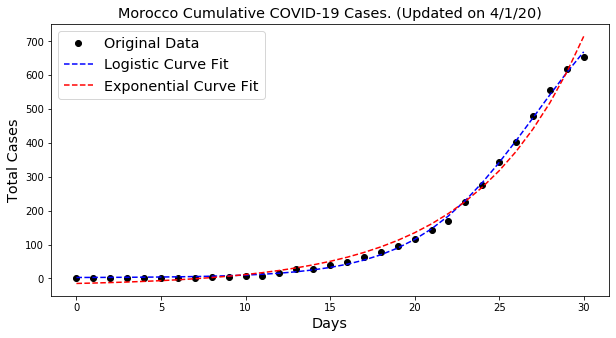



Lithuania

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 581
	Confirmed cases on 3/25/20 	 274
	Ratio: 2.12
	Weekly increase: 112.0 %
	Daily increase: 11.3 % per day
	Doubling Time (represents recent growth): 6.5 days

** Based on Logistic Fit**

	R^2: 0.9974457155434168
	Doubling Time (during middle of growth):  4.25 (± 0.38 ) days

** Based on Exponential Fit **

	R^2: 0.9754947237882134
	Doubling Time (represents overall growth):  5.11 (± 0.7 ) days


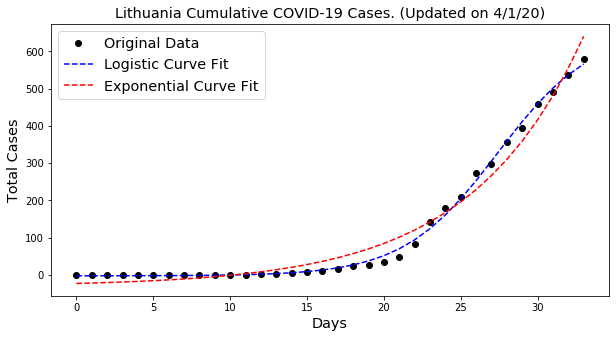



Armenia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 571
	Confirmed cases on 3/25/20 	 265
	Ratio: 2.15
	Weekly increase: 115.5 %
	Daily increase: 11.6 % per day
	Doubling Time (represents recent growth): 6.3 days

** Based on Logistic Fit**

	R^2: 0.9945290942930465
	Doubling Time (during middle of growth):  7.49 (± 1.33 ) days

** Based on Exponential Fit **

	R^2: 0.9894172893169326
	Doubling Time (represents overall growth):  6.56 (± 0.71 ) days


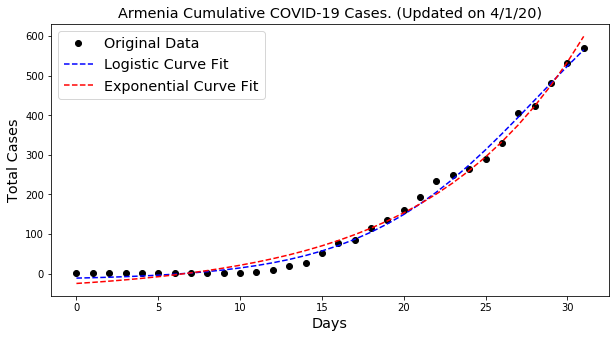



Bahrain

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 569
	Confirmed cases on 3/25/20 	 419
	Ratio: 1.36
	Weekly increase: 35.8 %
	Daily increase: 4.5 % per day
	Doubling Time (represents recent growth): 15.9 days

** Based on Logistic Fit**

	R^2: 0.9911172874492096
	Doubling Time (during middle of growth):  14.08 (± 4.4 ) days

** Based on Exponential Fit **

	R^2: 0.9858114915456002
	Doubling Time (represents overall growth):  13.19 (± 2.24 ) days


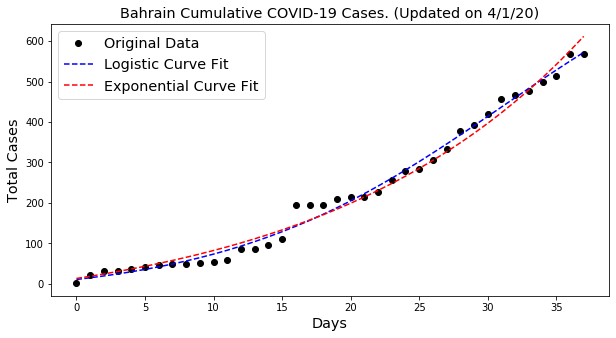



Hungary

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 525
	Confirmed cases on 3/25/20 	 226
	Ratio: 2.32
	Weekly increase: 132.3 %
	Daily increase: 12.8 % per day
	Doubling Time (represents recent growth): 5.8 days

** Based on Logistic Fit**

	R^2: 0.999365795085215
	Doubling Time (during middle of growth):  6.04 (± 0.36 ) days

** Based on Exponential Fit **

	R^2: 0.9931720317560678
	Doubling Time (represents overall growth):  5.55 (± 0.49 ) days


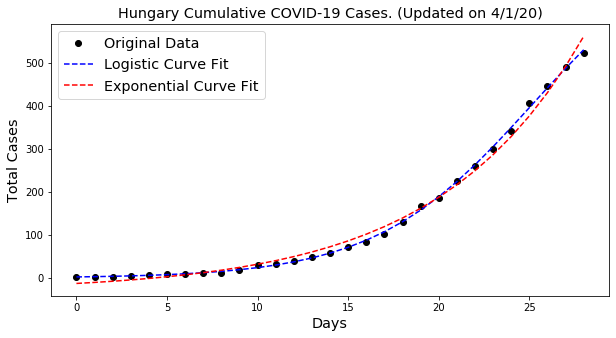



Lebanon

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 479
	Confirmed cases on 3/25/20 	 333
	Ratio: 1.44
	Weekly increase: 43.8 %
	Daily increase: 5.3 % per day
	Doubling Time (represents recent growth): 13.3 days

** Based on Logistic Fit**

	R^2: 0.9963099232163046
	Doubling Time (during middle of growth):  7.19 (± 0.74 ) days

** Based on Exponential Fit **

	R^2: 0.9811616686186648
	Doubling Time (represents overall growth):  9.16 (± 1.23 ) days


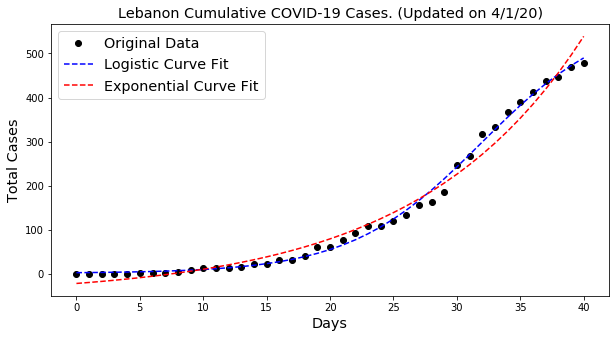



Bosnia and Herzegovina

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 459
	Confirmed cases on 3/25/20 	 176
	Ratio: 2.61
	Weekly increase: 160.8 %
	Daily increase: 14.7 % per day
	Doubling Time (represents recent growth): 5.1 days

** Based on Logistic Fit**

	R^2: 0.9957460207847613
	Doubling Time (during middle of growth):  8.11 (± 1.74 ) days

** Based on Exponential Fit **

	R^2: 0.9948408330009593
	Doubling Time (represents overall growth):  5.28 (± 0.41 ) days


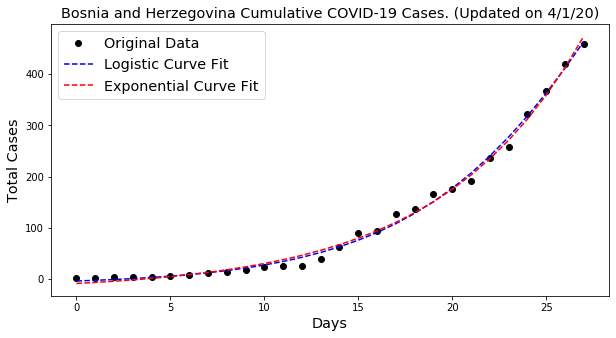



Latvia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 446
	Confirmed cases on 3/25/20 	 221
	Ratio: 2.02
	Weekly increase: 101.8 %
	Daily increase: 10.6 % per day
	Doubling Time (represents recent growth): 6.9 days

** Based on Logistic Fit**

	R^2: 0.9980997754247547
	Doubling Time (during middle of growth):  6.9 (± 0.7 ) days

** Based on Exponential Fit **

	R^2: 0.991077342728619
	Doubling Time (represents overall growth):  6.87 (± 0.73 ) days


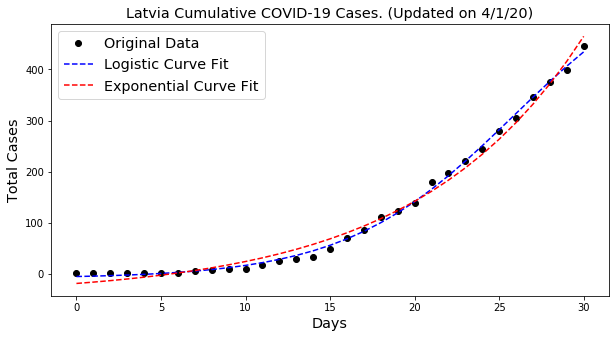



Tunisia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 423
	Confirmed cases on 3/25/20 	 173
	Ratio: 2.45
	Weekly increase: 144.5 %
	Daily increase: 13.6 % per day
	Doubling Time (represents recent growth): 5.4 days

** Based on Logistic Fit**

	R^2: 0.9951357761694812
	Doubling Time (during middle of growth):  4.91 (± 0.73 ) days

** Based on Exponential Fit **

	R^2: 0.9862327018067487
	Doubling Time (represents overall growth):  4.81 (± 0.56 ) days


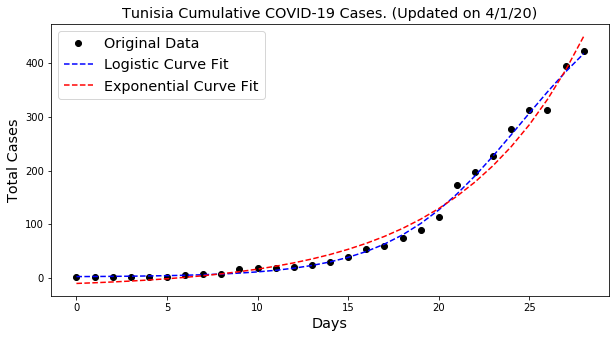



Moldova

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 423
	Confirmed cases on 3/25/20 	 149
	Ratio: 2.84
	Weekly increase: 183.9 %
	Daily increase: 16.1 % per day
	Doubling Time (represents recent growth): 4.7 days

** Based on Logistic Fit**

	R^2: 0.9980049818453794
	Doubling Time (during middle of growth):  10.15 (± nan ) days

** Based on Exponential Fit **

	R^2: 0.998004982013049
	Doubling Time (represents overall growth):  5.07 (± 0.27 ) days


C:\Users\alibe\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt


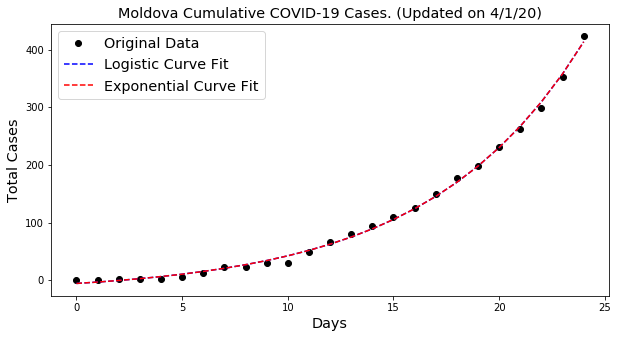



Bulgaria

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 422
	Confirmed cases on 3/25/20 	 242
	Ratio: 1.74
	Weekly increase: 74.4 %
	Daily increase: 8.3 % per day
	Doubling Time (represents recent growth): 8.7 days

** Based on Logistic Fit**

	R^2: 0.996742829330236
	Doubling Time (during middle of growth):  7.91 (± 1.55 ) days

** Based on Exponential Fit **

	R^2: 0.9889905510966217
	Doubling Time (represents overall growth):  9.47 (± 1.94 ) days


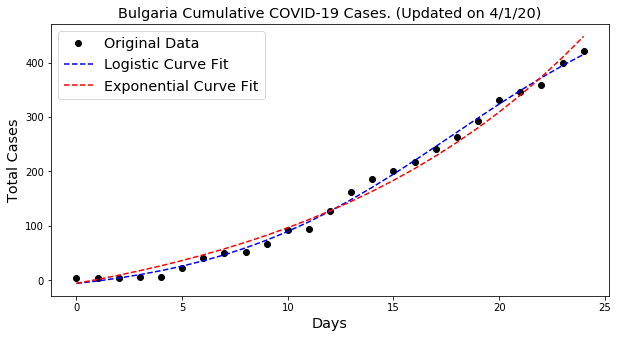



Slovakia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 400
	Confirmed cases on 3/25/20 	 216
	Ratio: 1.85
	Weekly increase: 85.2 %
	Daily increase: 9.2 % per day
	Doubling Time (represents recent growth): 7.9 days

** Based on Logistic Fit**

	R^2: 0.9924777025665288
	Doubling Time (during middle of growth):  12.27 (± 5.78 ) days

** Based on Exponential Fit **

	R^2: 0.9902607681968983
	Doubling Time (represents overall growth):  10.43 (± 1.94 ) days


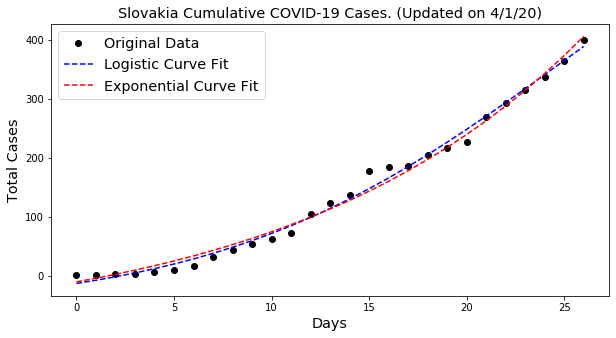



Andorra

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 390
	Confirmed cases on 3/25/20 	 188
	Ratio: 2.07
	Weekly increase: 107.4 %
	Daily increase: 11.0 % per day
	Doubling Time (represents recent growth): 6.6 days

** Based on Logistic Fit**

	R^2: 0.9972740797753563
	Doubling Time (during middle of growth):  4.57 (± 0.45 ) days

** Based on Exponential Fit **

	R^2: 0.9738107104176453
	Doubling Time (represents overall growth):  6.07 (± 1.04 ) days


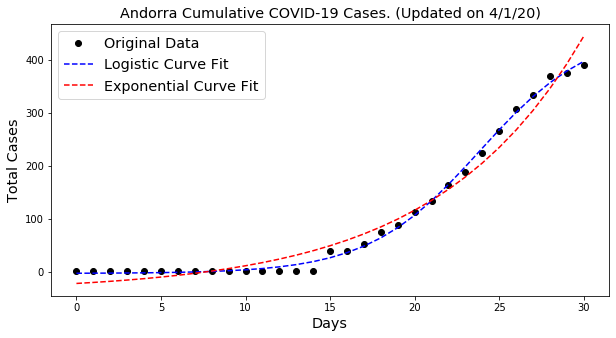



Kazakhstan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 380
	Confirmed cases on 3/25/20 	 81
	Ratio: 4.69
	Weekly increase: 369.1 %
	Daily increase: 24.7 % per day
	Doubling Time (represents recent growth): 3.1 days

** Based on Logistic Fit**

	R^2: 0.9862546706947487
	Doubling Time (during middle of growth):  3.04 (± 0.89 ) days

** Based on Exponential Fit **

	R^2: 0.9745131855007174
	Doubling Time (represents overall growth):  4.01 (± 0.88 ) days


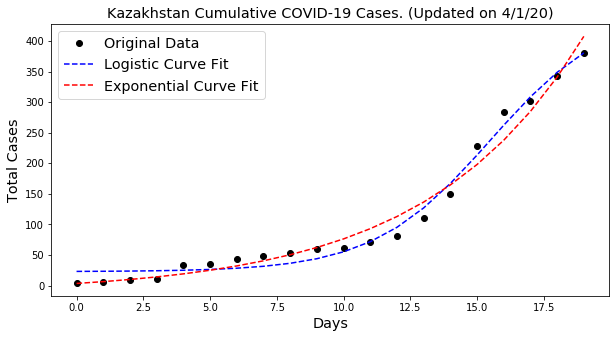



Costa Rica

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 375
	Confirmed cases on 3/25/20 	 201
	Ratio: 1.87
	Weekly increase: 86.6 %
	Daily increase: 9.3 % per day
	Doubling Time (represents recent growth): 7.8 days

** Based on Logistic Fit**

	R^2: 0.9986623523468734
	Doubling Time (during middle of growth):  5.5 (± 0.45 ) days

** Based on Exponential Fit **

	R^2: 0.984850155322931
	Doubling Time (represents overall growth):  8.16 (± 1.54 ) days


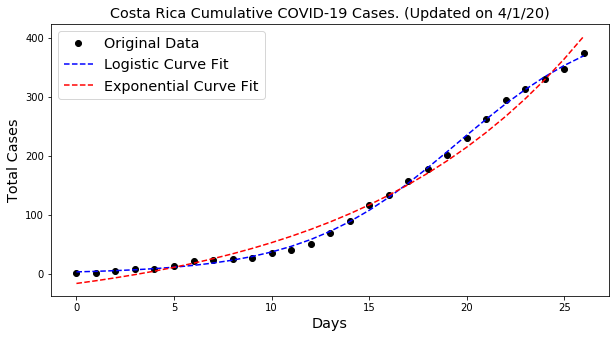



Azerbaijan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 359
	Confirmed cases on 3/25/20 	 93
	Ratio: 3.86
	Weekly increase: 286.0 %
	Daily increase: 21.3 % per day
	Doubling Time (represents recent growth): 3.6 days

** Based on Logistic Fit**

	R^2: 0.9968834934668053
	Doubling Time (during middle of growth):  7.09 (± 1.05 ) days

** Based on Exponential Fit **

	R^2: 0.9967019211820127
	Doubling Time (represents overall growth):  3.92 (± 0.19 ) days


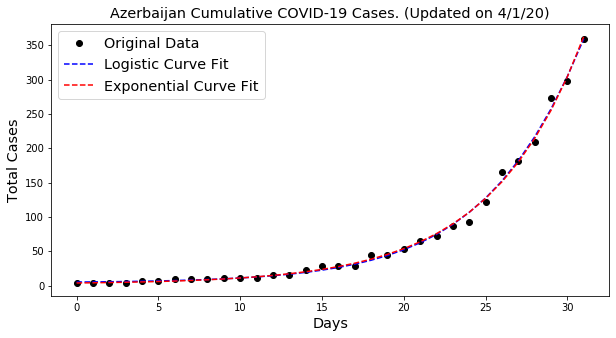



North Macedonia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 354
	Confirmed cases on 3/25/20 	 177
	Ratio: 2.0
	Weekly increase: 100.0 %
	Daily increase: 10.4 % per day
	Doubling Time (represents recent growth): 7.0 days

** Based on Logistic Fit**

	R^2: 0.9960021266805398
	Doubling Time (during middle of growth):  5.69 (± 0.65 ) days

** Based on Exponential Fit **

	R^2: 0.9836507663019962
	Doubling Time (represents overall growth):  5.87 (± 0.66 ) days


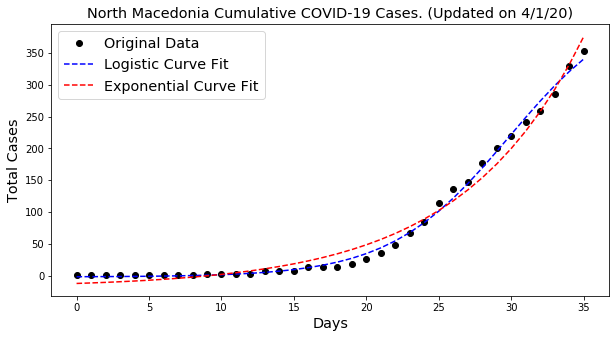



Uruguay

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 338
	Confirmed cases on 3/25/20 	 189
	Ratio: 1.79
	Weekly increase: 78.8 %
	Daily increase: 8.7 % per day
	Doubling Time (represents recent growth): 8.3 days

** Based on Logistic Fit**

	R^2: 0.9918796334921852
	Doubling Time (during middle of growth):  9.35 (± 6.27 ) days

** Based on Exponential Fit **

	R^2: 0.9633875971182516
	Doubling Time (represents overall growth):  8.14 (± 4.04 ) days


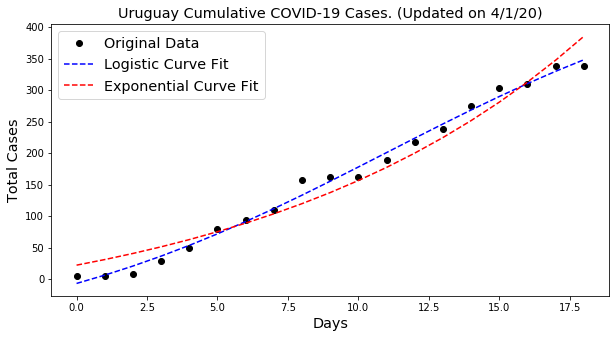



Taiwan*

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 329
	Confirmed cases on 3/25/20 	 235
	Ratio: 1.4
	Weekly increase: 40.0 %
	Daily increase: 4.9 % per day
	Doubling Time (represents recent growth): 14.4 days

** Based on Logistic Fit**

	R^2: 0.9876980210632195
	Doubling Time (during middle of growth):  6.83 (± 0.91 ) days

** Based on Exponential Fit **

	R^2: 0.9759680735690185
	Doubling Time (represents overall growth):  7.78 (± 0.64 ) days


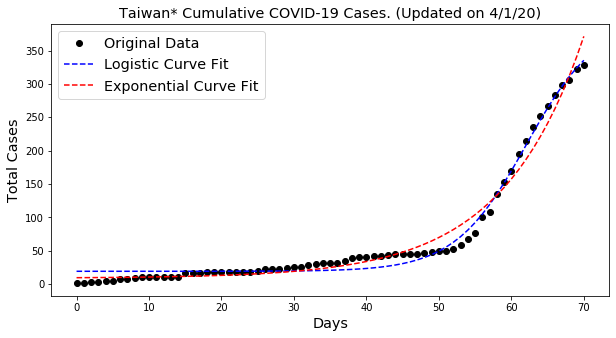



Cyprus

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 320
	Confirmed cases on 3/25/20 	 132
	Ratio: 2.42
	Weekly increase: 142.4 %
	Daily increase: 13.5 % per day
	Doubling Time (represents recent growth): 5.5 days

** Based on Logistic Fit**

	R^2: 0.9935876004804347
	Doubling Time (during middle of growth):  13.89 (± 3.09 ) days

** Based on Exponential Fit **

	R^2: 0.9935876008698038
	Doubling Time (represents overall growth):  6.95 (± 0.88 ) days


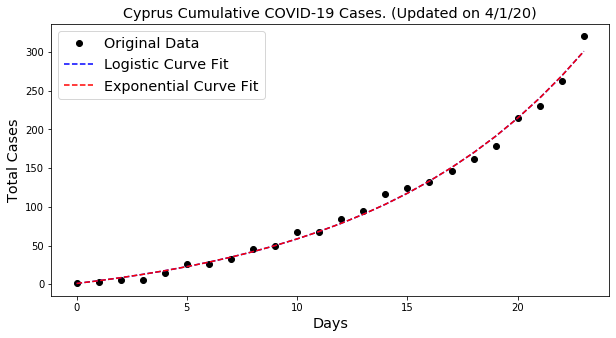



Kuwait

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 317
	Confirmed cases on 3/25/20 	 195
	Ratio: 1.63
	Weekly increase: 62.6 %
	Daily increase: 7.2 % per day
	Doubling Time (represents recent growth): 10.0 days

** Based on Logistic Fit**

	R^2: 0.9872285473505067
	Doubling Time (during middle of growth):  27.18 (± 29.32 ) days

** Based on Exponential Fit **

	R^2: 0.9872285483146631
	Doubling Time (represents overall growth):  13.59 (± 2.23 ) days


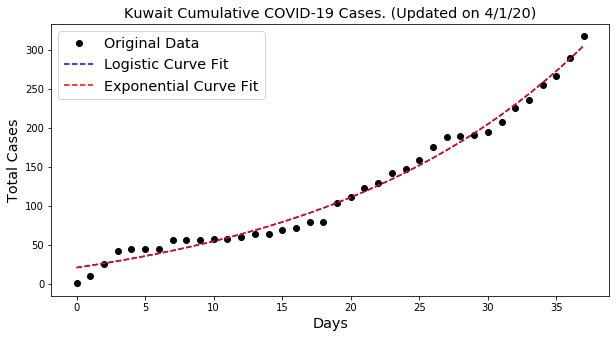



Burkina Faso

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 282
	Confirmed cases on 3/25/20 	 146
	Ratio: 1.93
	Weekly increase: 93.2 %
	Daily increase: 9.9 % per day
	Doubling Time (represents recent growth): 7.4 days

** Based on Logistic Fit**

	R^2: 0.9979788234544339
	Doubling Time (during middle of growth):  5.04 (± 0.58 ) days

** Based on Exponential Fit **

	R^2: 0.9850974644983306
	Doubling Time (represents overall growth):  7.72 (± 1.73 ) days


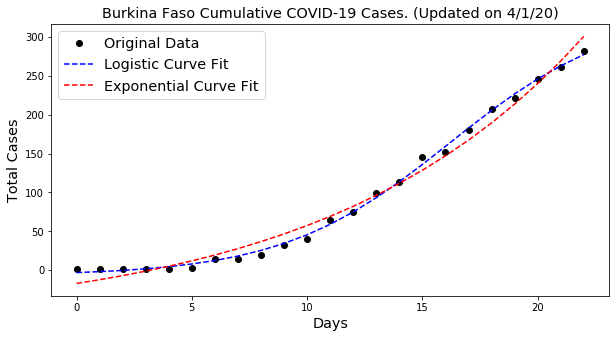



Jordan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 278
	Confirmed cases on 3/25/20 	 172
	Ratio: 1.62
	Weekly increase: 61.6 %
	Daily increase: 7.1 % per day
	Doubling Time (represents recent growth): 10.1 days

** Based on Logistic Fit**

	R^2: 0.9959963697299257
	Doubling Time (during middle of growth):  4.41 (± 0.51 ) days

** Based on Exponential Fit **

	R^2: 0.9604429286131917
	Doubling Time (represents overall growth):  8.59 (± 2.4 ) days


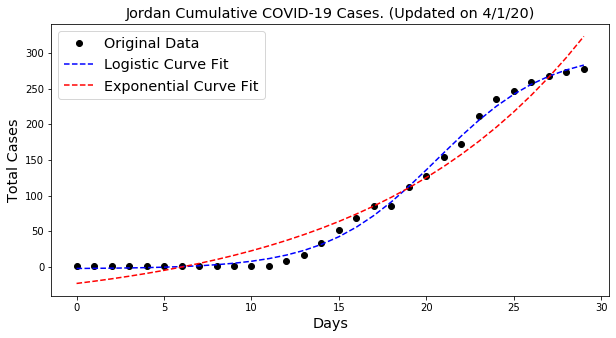



Albania

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 259
	Confirmed cases on 3/25/20 	 146
	Ratio: 1.77
	Weekly increase: 77.4 %
	Daily increase: 8.5 % per day
	Doubling Time (represents recent growth): 8.5 days

** Based on Logistic Fit**

	R^2: 0.9919891609152036
	Doubling Time (during middle of growth):  7.6 (± 2.44 ) days

** Based on Exponential Fit **

	R^2: 0.9887825629783378
	Doubling Time (represents overall growth):  9.74 (± 2.16 ) days


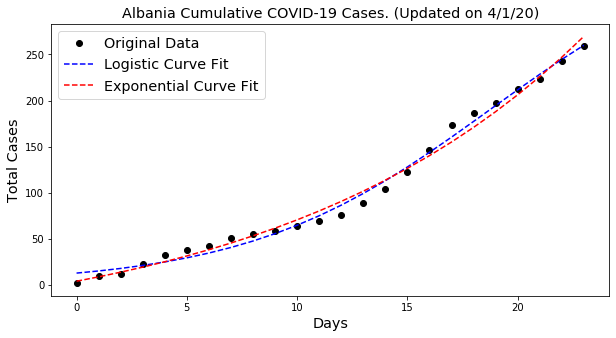



Afghanistan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 237
	Confirmed cases on 3/25/20 	 84
	Ratio: 2.82
	Weekly increase: 182.1 %
	Daily increase: 16.0 % per day
	Doubling Time (represents recent growth): 4.7 days

** Based on Logistic Fit**

	R^2: 0.9853234065275616
	Doubling Time (during middle of growth):  8.46 (± 2.47 ) days

** Based on Exponential Fit **

	R^2: 0.9853234071918132
	Doubling Time (represents overall growth):  4.23 (± 0.38 ) days


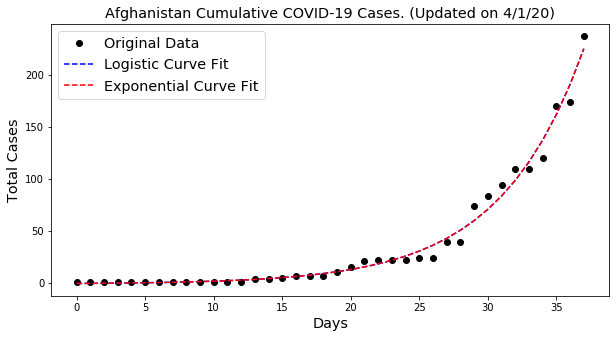



San Marino

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 236
	Confirmed cases on 3/25/20 	 208
	Ratio: 1.13
	Weekly increase: 13.5 %
	Daily increase: 1.8 % per day
	Doubling Time (represents recent growth): 38.4 days

** Based on Logistic Fit**

	R^2: 0.9946672291307689
	Doubling Time (during middle of growth):  8.97 (± 1.45 ) days

** Based on Exponential Fit **

	R^2: 0.9743908851121711
	Doubling Time (represents overall growth):  17.59 (± 5.91 ) days


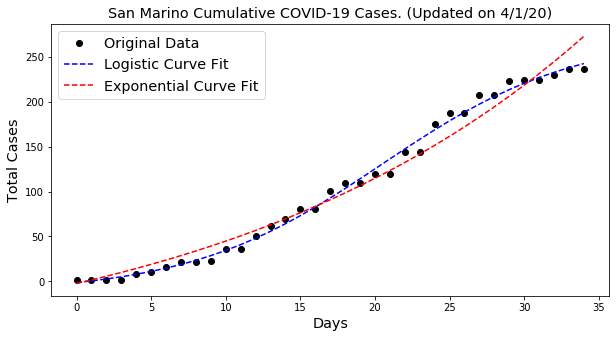



Cameroon

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 233
	Confirmed cases on 3/25/20 	 75
	Ratio: 3.11
	Weekly increase: 210.7 %
	Daily increase: 17.6 % per day
	Doubling Time (represents recent growth): 4.3 days

** Based on Logistic Fit**

	R^2: 0.9854651880307577
	Doubling Time (during middle of growth):  7.88 (± 2.02 ) days

** Based on Exponential Fit **

	R^2: 0.9854651887077086
	Doubling Time (represents overall growth):  3.94 (± 0.47 ) days


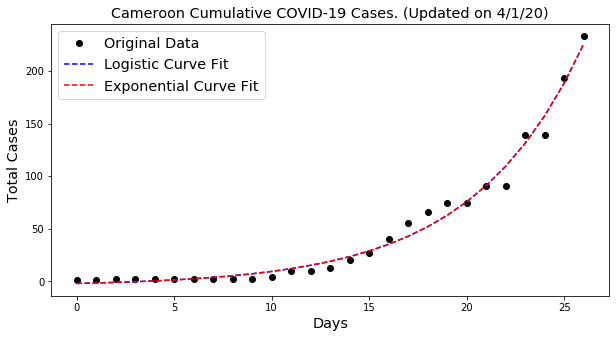



Vietnam

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 218
	Confirmed cases on 3/25/20 	 141
	Ratio: 1.55
	Weekly increase: 54.6 %
	Daily increase: 6.4 % per day
	Doubling Time (represents recent growth): 11.1 days

** Based on Logistic Fit**

	R^2: 0.9945643458451436
	Doubling Time (during middle of growth):  9.59 (± 0.92 ) days

** Based on Exponential Fit **

	R^2: 0.9881674308290803
	Doubling Time (represents overall growth):  8.06 (± 0.47 ) days


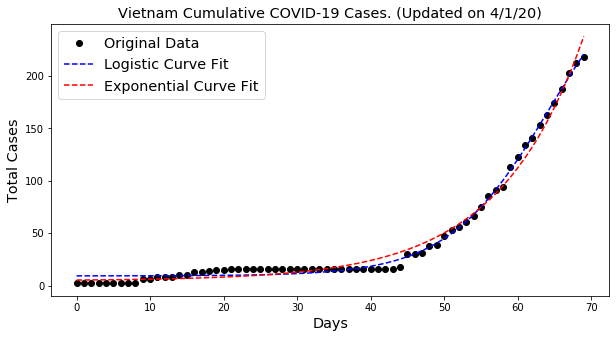



Cuba

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 212
	Confirmed cases on 3/25/20 	 57
	Ratio: 3.72
	Weekly increase: 271.9 %
	Daily increase: 20.6 % per day
	Doubling Time (represents recent growth): 3.7 days

** Based on Logistic Fit**

	R^2: 0.9954910394099322
	Doubling Time (during middle of growth):  4.65 (± 0.94 ) days

** Based on Exponential Fit **

	R^2: 0.990618647323285
	Doubling Time (represents overall growth):  4.1 (± 0.52 ) days


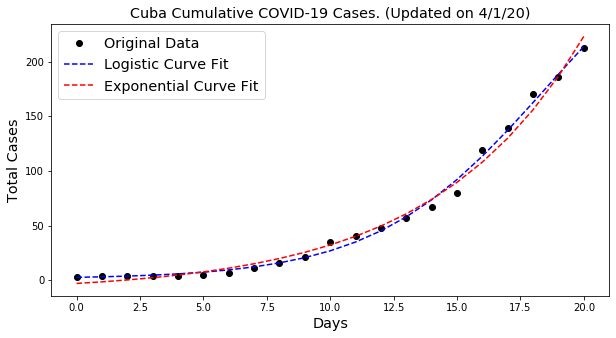



Oman

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 210
	Confirmed cases on 3/25/20 	 99
	Ratio: 2.12
	Weekly increase: 112.1 %
	Daily increase: 11.3 % per day
	Doubling Time (represents recent growth): 6.5 days

** Based on Logistic Fit**

	R^2: 0.9942612150732634
	Doubling Time (during middle of growth):  6.4 (± 0.92 ) days

** Based on Exponential Fit **

	R^2: 0.9886016359533242
	Doubling Time (represents overall growth):  5.55 (± 0.48 ) days


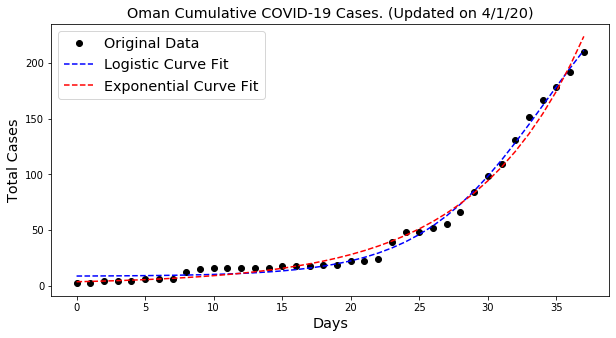



Ghana

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 195
	Confirmed cases on 3/25/20 	 93
	Ratio: 2.1
	Weekly increase: 109.7 %
	Daily increase: 11.2 % per day
	Doubling Time (represents recent growth): 6.6 days

** Based on Logistic Fit**

	R^2: 0.9809296987758838
	Doubling Time (during middle of growth):  1.83 (± 0.6 ) days


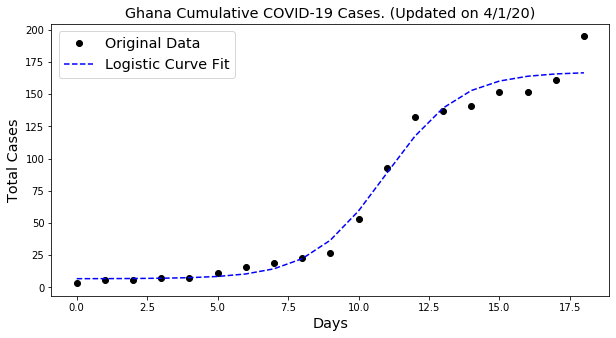



Cote d'Ivoire

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 190
	Confirmed cases on 3/25/20 	 80
	Ratio: 2.38
	Weekly increase: 137.5 %
	Daily increase: 13.2 % per day
	Doubling Time (represents recent growth): 5.6 days

** Based on Logistic Fit**

	R^2: 0.9774312767040848
	Doubling Time (during middle of growth):  3.65 (± 1.29 ) days

** Based on Exponential Fit **

	R^2: 0.9558273007156223
	Doubling Time (represents overall growth):  5.26 (± 1.63 ) days


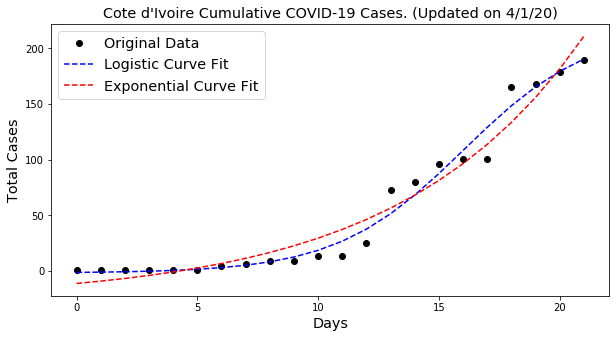



Senegal

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 190
	Confirmed cases on 3/25/20 	 99
	Ratio: 1.92
	Weekly increase: 91.9 %
	Daily increase: 9.8 % per day
	Doubling Time (represents recent growth): 7.4 days

** Based on Logistic Fit**

	R^2: 0.9958319328489568
	Doubling Time (during middle of growth):  6.89 (± 1.03 ) days

** Based on Exponential Fit **

	R^2: 0.9893251607314779
	Doubling Time (represents overall growth):  6.71 (± 0.77 ) days


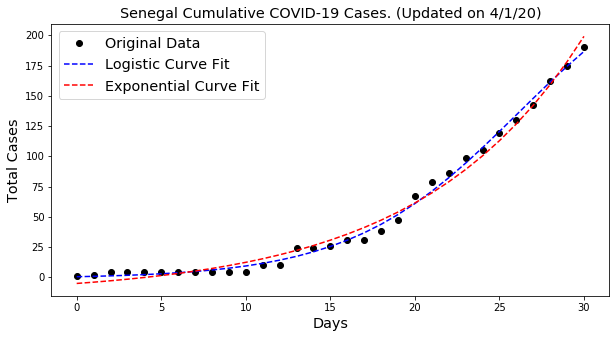



Malta

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 188
	Confirmed cases on 3/25/20 	 129
	Ratio: 1.46
	Weekly increase: 45.7 %
	Daily increase: 5.5 % per day
	Doubling Time (represents recent growth): 12.9 days

** Based on Logistic Fit**

	R^2: 0.994575624425257
	Doubling Time (during middle of growth):  5.61 (± 0.95 ) days

** Based on Exponential Fit **

	R^2: 0.978419737196232
	Doubling Time (represents overall growth):  14.68 (± 5.85 ) days


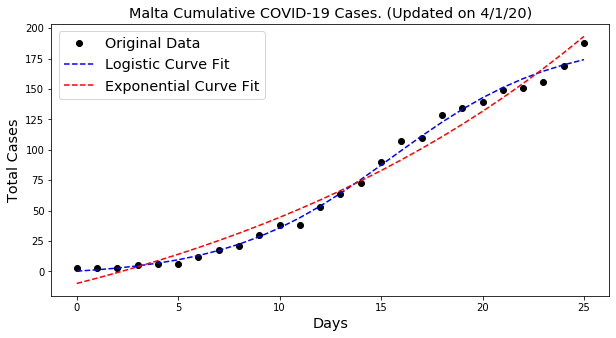



Uzbekistan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 181
	Confirmed cases on 3/25/20 	 60
	Ratio: 3.02
	Weekly increase: 201.7 %
	Daily increase: 17.1 % per day
	Doubling Time (represents recent growth): 4.4 days

** Based on Logistic Fit**

	R^2: 0.9857261094752224
	Doubling Time (during middle of growth):  7.15 (± 5.13 ) days

** Based on Exponential Fit **

	R^2: 0.9849656855697682
	Doubling Time (represents overall growth):  5.75 (± 1.44 ) days


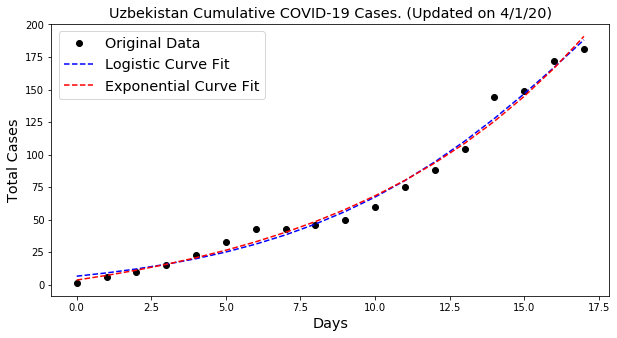



Nigeria

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 174
	Confirmed cases on 3/25/20 	 51
	Ratio: 3.41
	Weekly increase: 241.2 %
	Daily increase: 19.2 % per day
	Doubling Time (represents recent growth): 4.0 days

** Based on Logistic Fit**

	R^2: 0.993894778075039
	Doubling Time (during middle of growth):  5.65 (± 0.93 ) days

** Based on Exponential Fit **

	R^2: 0.9906092320864676
	Doubling Time (represents overall growth):  3.99 (± 0.31 ) days


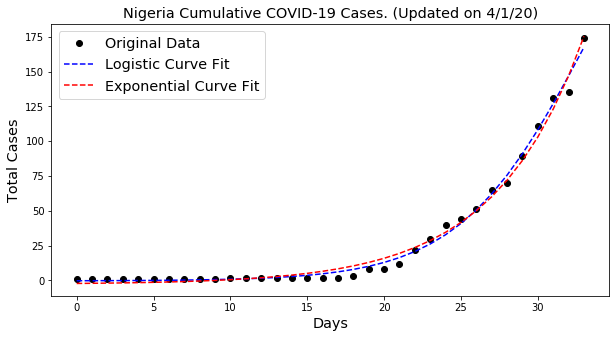



Honduras

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 172
	Confirmed cases on 3/25/20 	 36
	Ratio: 4.78
	Weekly increase: 377.8 %
	Daily increase: 25.0 % per day
	Doubling Time (represents recent growth): 3.1 days

** Based on Logistic Fit**

	R^2: 0.9896209873070752
	Doubling Time (during middle of growth):  4.48 (± 1.29 ) days

** Based on Exponential Fit **

	R^2: 0.9854372269537351
	Doubling Time (represents overall growth):  3.9 (± 0.57 ) days


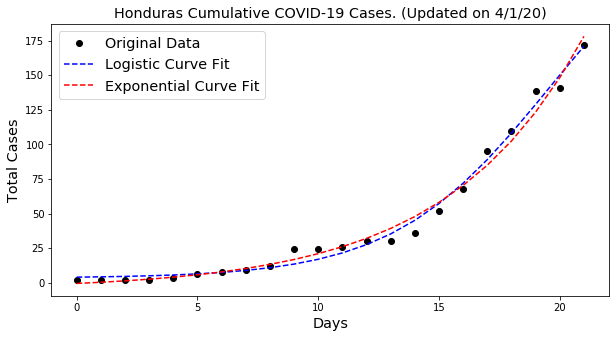



Belarus

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 163
	Confirmed cases on 3/25/20 	 86
	Ratio: 1.9
	Weekly increase: 89.5 %
	Daily increase: 9.6 % per day
	Doubling Time (represents recent growth): 7.6 days

** Based on Logistic Fit**

	R^2: 0.9619468282903902
	Doubling Time (during middle of growth):  19.14 (± 27.3 ) days

** Based on Exponential Fit **

	R^2: 0.9619468317705301
	Doubling Time (represents overall growth):  9.57 (± 2.41 ) days


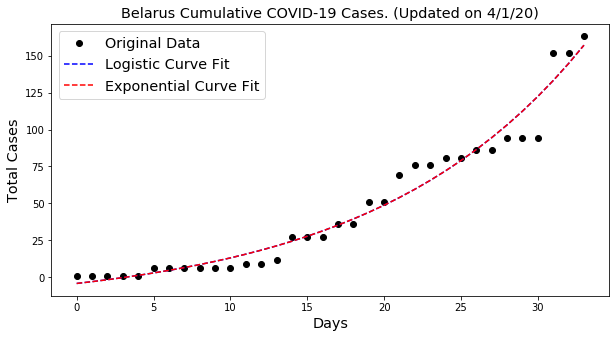



Mauritius

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 161
	Confirmed cases on 3/25/20 	 48
	Ratio: 3.35
	Weekly increase: 235.4 %
	Daily increase: 18.9 % per day
	Doubling Time (represents recent growth): 4.0 days

** Based on Logistic Fit**

	R^2: 0.9897955858324292
	Doubling Time (during middle of growth):  5.8 (± 3.62 ) days

** Based on Exponential Fit **

	R^2: 0.9873590956508433
	Doubling Time (represents overall growth):  9.66 (± 4.62 ) days


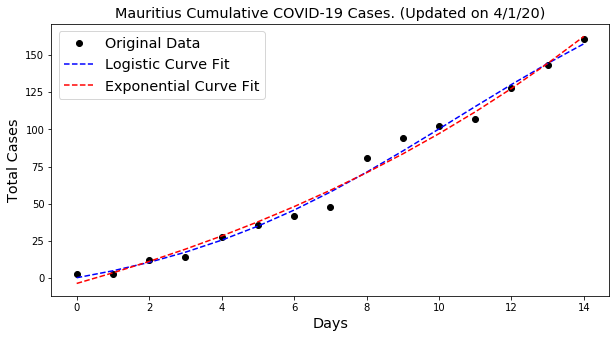



Sri Lanka

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 146
	Confirmed cases on 3/25/20 	 102
	Ratio: 1.43
	Weekly increase: 43.1 %
	Daily increase: 5.3 % per day
	Doubling Time (represents recent growth): 13.5 days

** Based on Logistic Fit**

	R^2: 0.9884683255408335
	Doubling Time (during middle of growth):  4.47 (± 0.58 ) days


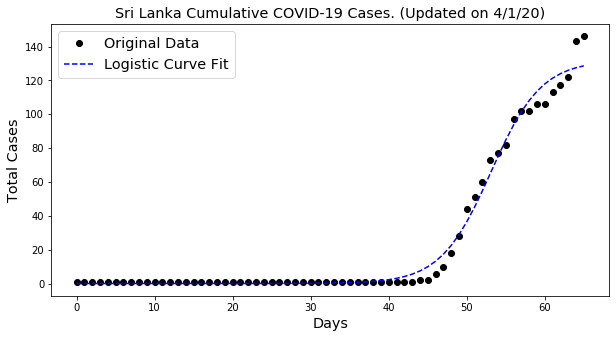



Venezuela

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 143
	Confirmed cases on 3/25/20 	 91
	Ratio: 1.57
	Weekly increase: 57.1 %
	Daily increase: 6.7 % per day
	Doubling Time (represents recent growth): 10.7 days

** Based on Logistic Fit**

	R^2: 0.9908960115336698
	Doubling Time (during middle of growth):  13.97 (± 19.72 ) days

** Based on Exponential Fit **

	R^2: 0.9665026608193565
	Doubling Time (represents overall growth):  14.22 (± 11.28 ) days


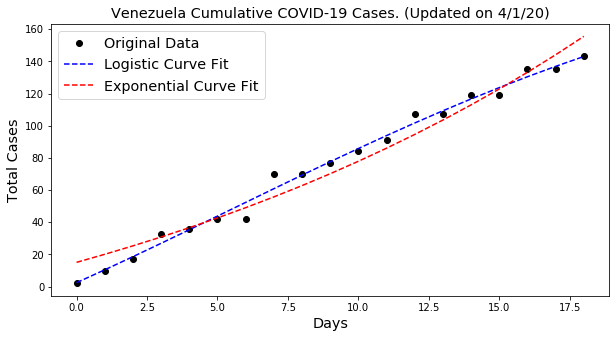



West Bank and Gaza

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 134
	Confirmed cases on 3/25/20 	 59
	Ratio: 2.27
	Weekly increase: 127.1 %
	Daily increase: 12.4 % per day
	Doubling Time (represents recent growth): 5.9 days

** Based on Logistic Fit**

	R^2: 0.9762964229269965
	Doubling Time (during middle of growth):  15.7 (± 11.04 ) days

** Based on Exponential Fit **

	R^2: 0.9762964244442113
	Doubling Time (represents overall growth):  7.85 (± 1.72 ) days


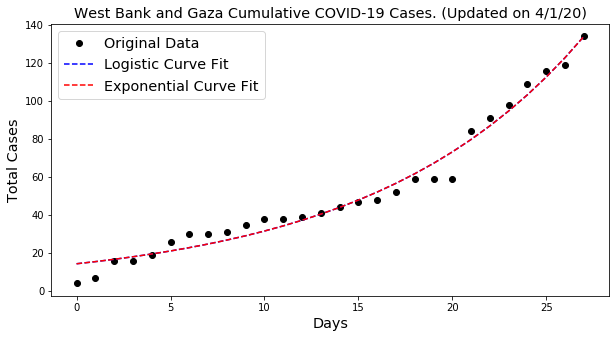



Brunei

** Based on Most Recent Week of Data **

	Confirmed cases on 4/1/20 	 131
	Confirmed cases on 3/25/20 	 109
	Ratio: 1.2
	Weekly increase: 20.2 %
	Daily increase: 2.7 % per day
	Doubling Time (represents recent growth): 26.4 days

** Based on Logistic Fit**

	R^2: 0.9919298114338126
	Doubling Time (during middle of growth):  15.49 (± 14.28 ) days


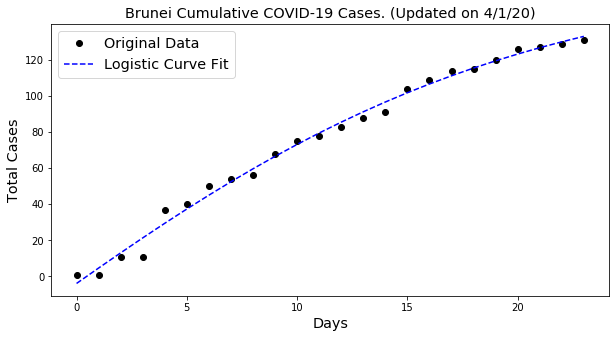



Kosovo


IndexError: index -8 is out of bounds for axis 0 with size 7

In [7]:
topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
print('\n')

for c in topcountries:
    print(c)
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for Global COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


     Inferred Doubling Time  95%CI  Recent Doubling Time
0                       3.8    0.2                   4.1
1                       7.7    0.2                  12.2
2                       6.2    0.2                   6.5
3                       6.5    0.5                 568.5
4                       6.3    0.2                   6.6
..                      ...    ...                   ...
99                      9.7    4.6                   4.0
100                     4.5    0.6                  13.5
101                    14.0   19.7                  10.7
102                     7.8    1.7                   5.9
103                    15.5   14.3                  26.4

[104 rows x 3 columns]




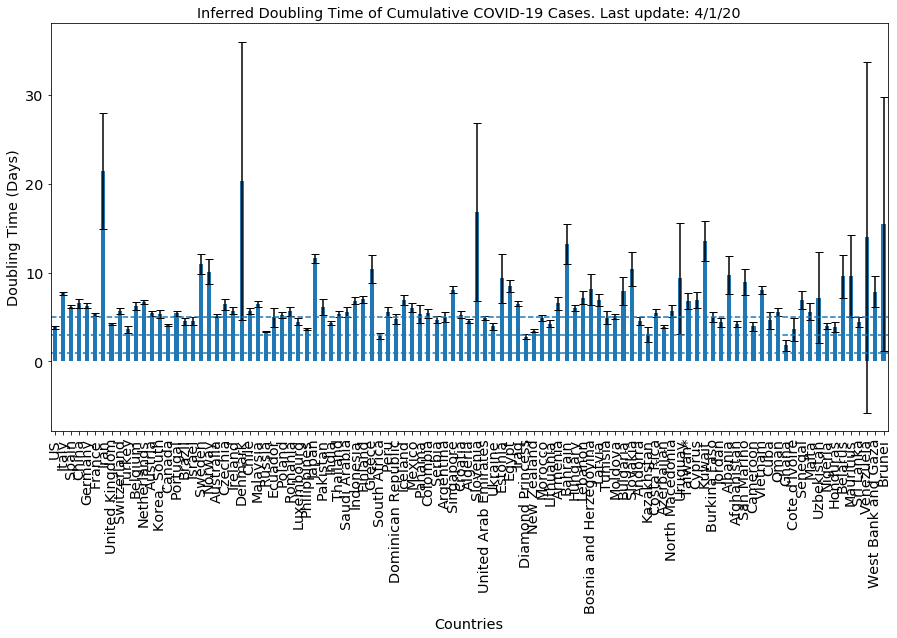

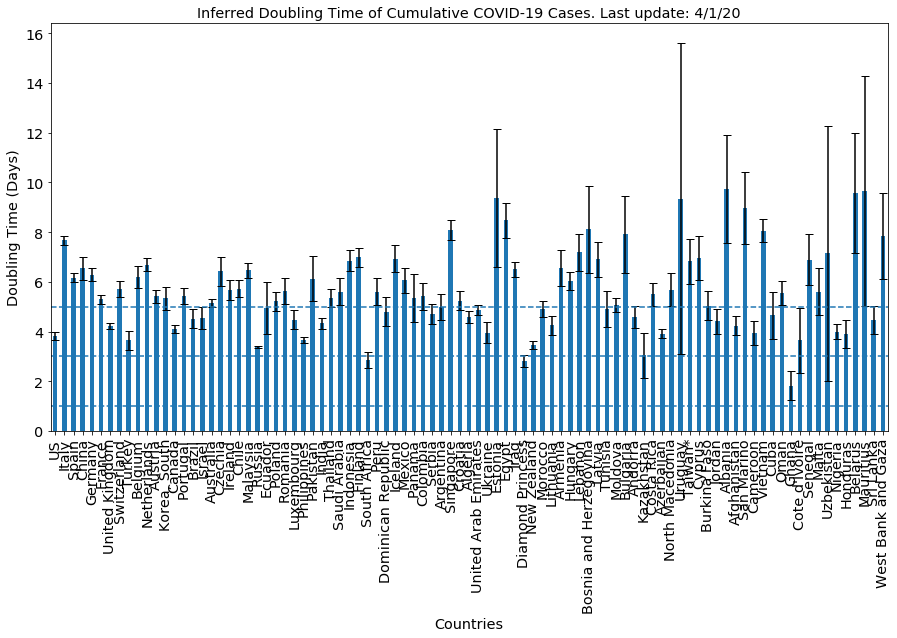

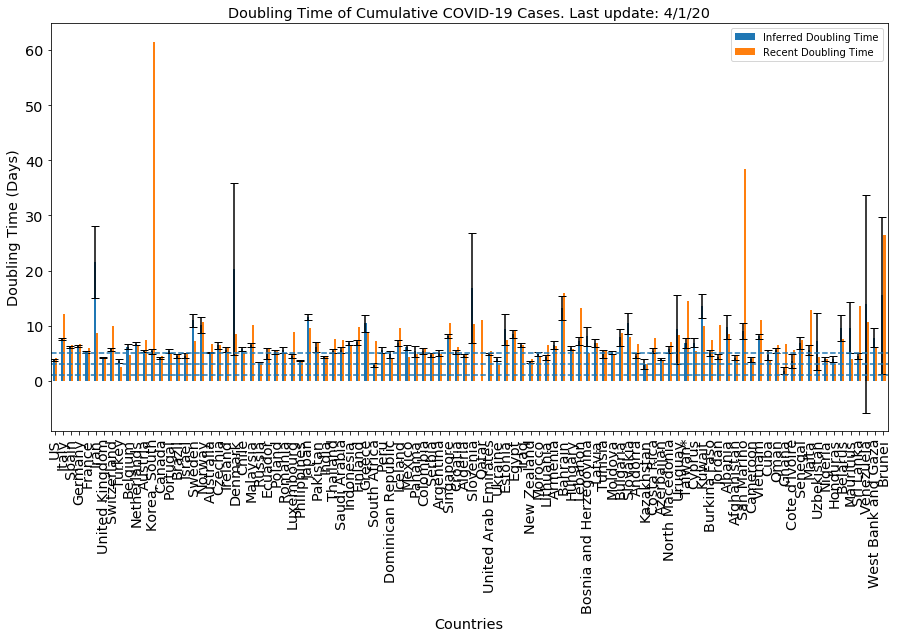

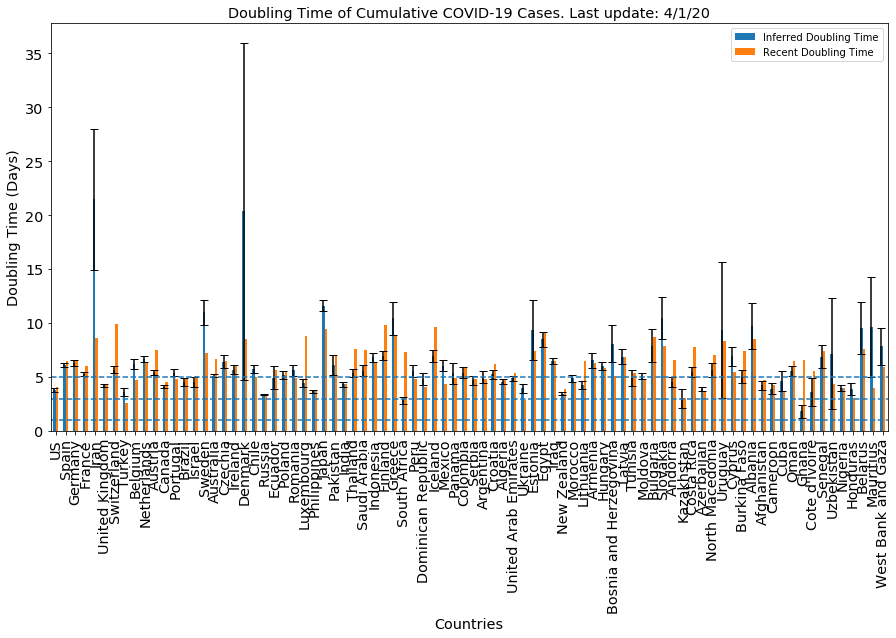

In [8]:
d = {'Countries': countries, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')

print(pd.DataFrame(data=d).iloc[:,[1,2,3]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 10]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=countries
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 10]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

## US COVID-19 Analysis

In [9]:
uscases = df[df['Country/Region'] == 'US'].copy()

# US states lookup from https://code.activestate.com/recipes/577305-python-dictionary-of-us-states-and-territories/
# with DC added
states = { 'AK': 'Alaska', 'AL': 'Alabama', 'AR': 'Arkansas', 'AS': 'American Samoa', 'AZ': 'Arizona', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DC': 'District of Columbia', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'GU': 'Guam', 'HI': 'Hawaii', 'IA': 'Iowa', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'MA': 'Massachusetts', 'MD': 'Maryland', 'ME': 'Maine', 'MI': 'Michigan', 'MN': 'Minnesota', 'MO': 'Missouri', 'MP': 'Northern Mariana Islands', 'MS': 'Mississippi', 'MT': 'Montana', 'NA': 'National', 'NC': 'North Carolina', 'ND': 'North Dakota', 'NE': 'Nebraska', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NV': 'Nevada', 'NY': 'New York', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'PR': 'Puerto Rico', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VA': 'Virginia', 'VI': 'Virgin Islands', 'VT': 'Vermont', 'WA': 'Washington', 'WI': 'Wisconsin', 'WV': 'West Virginia', 'WY': 'Wyoming', 'D.C.': 'District of Columbia'}

for index, row in uscases.iterrows():
    location = row['Province/State']
    try:
        if ',' in location:
            result = [x.strip() for x in location.split(',')]
            statename = states[result[1]]
            row['State'] = statename
            uscases.loc[index, 'Province/State'] = statename
    except:
        print('Error parsing US state:', location)        
            
usstatesummary = uscases.iloc[:,[0,-1]].groupby('Province/State').sum()
mostrecentdate = usstatesummary.columns[0]
usstatesummary = usstatesummary.sort_values(by = mostrecentdate, ascending = False)
usstatesummary = usstatesummary[usstatesummary[mostrecentdate] > 0]

print('\nNumber of confirmed US COVID-19 cases by state as of', mostrecentdate)
usstatesummary

Error parsing US state: nan

Number of confirmed US COVID-19 cases by state as of 4/1/20


Empty DataFrame
Columns: [4/1/20]
Index: []

## Curve Fitting US COVID-19 Cases

In [10]:
topusstates = usstatesummary[usstatesummary[mostrecentdate] >= 100]
print(topusstates)

print('\n');
inferreddoublingtime = []
recentdoublingtime = []
errors = []
states = []

for state in topusstates.index.values:
    print('US state: ', state)
    a = plotCases(uscases,'Province/State', state)
    if a:
        states.append(state)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

Empty DataFrame
Columns: [4/1/20]
Index: []




## Doubling Times for US COVID-19 Cases

In [11]:
d = {'States': states, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')
print(pd.DataFrame(data=d).iloc[:,[3,1,2]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'States', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Inferred Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=states
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=states)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(yerr=err, figsize=(10,5), fontsize="x-large")
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


Empty DataFrame
Columns: [Recent Doubling Time, Inferred Doubling Time, 95%CI]
Index: []




TypeError: no numeric data to plot